In [7]:
# General Imports
import os
import numpy as np
import pandas as pd
from time import strftime, localtime
import matplotlib.pyplot as plt
#from utilities import create_analysis_report, load_validation_set_raw
from skimage.transform import resize

import seaborn as sn
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, cohen_kappa_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score, \
    hamming_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import check_random_state
import seaborn as sn 
sn.set(font_scale=3)  # for label size

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## RESNET + BALANCED 

In [52]:
OUTPUT_PATH ="/srv/workspace/research/mlml/experiments_results_nus/"
OCE_results_pd = pd.DataFrame()
for split in np.arange(1,5):
    for ratio in np.arange(0,1,0.25): 
        experiment_path = OUTPUT_PATH+'nus_3labels_original_CE'  + str(round(ratio, 1)) + 'split_' + str(split)
        dirs = os.listdir(experiment_path)
        split_ratio_results = pd.read_csv(experiment_path + '/' + dirs[0] + '/results_report.csv')
        split_ratio_results['ratio'] = ratio
        #split_ratio_results['split'] = split 
        split_ratio_results.rename(columns={"Unnamed: 0" : 'Class'},inplace=True)
        OCE_results_pd = pd.concat([OCE_results_pd,split_ratio_results[split_ratio_results.Class == 'average']])

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_core.py:2254: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  return_type=return_type, **kwds)


[Text(0.5, 0, 'Ratio'),
 Text(0.5, 0, 'Ratio'),
 Text(0.5, 0, 'Ratio'),
 Text(0.5, 0, 'Ratio'),
 Text(0.5, 0, 'Ratio'),
 Text(0.5, 0, 'Ratio')]

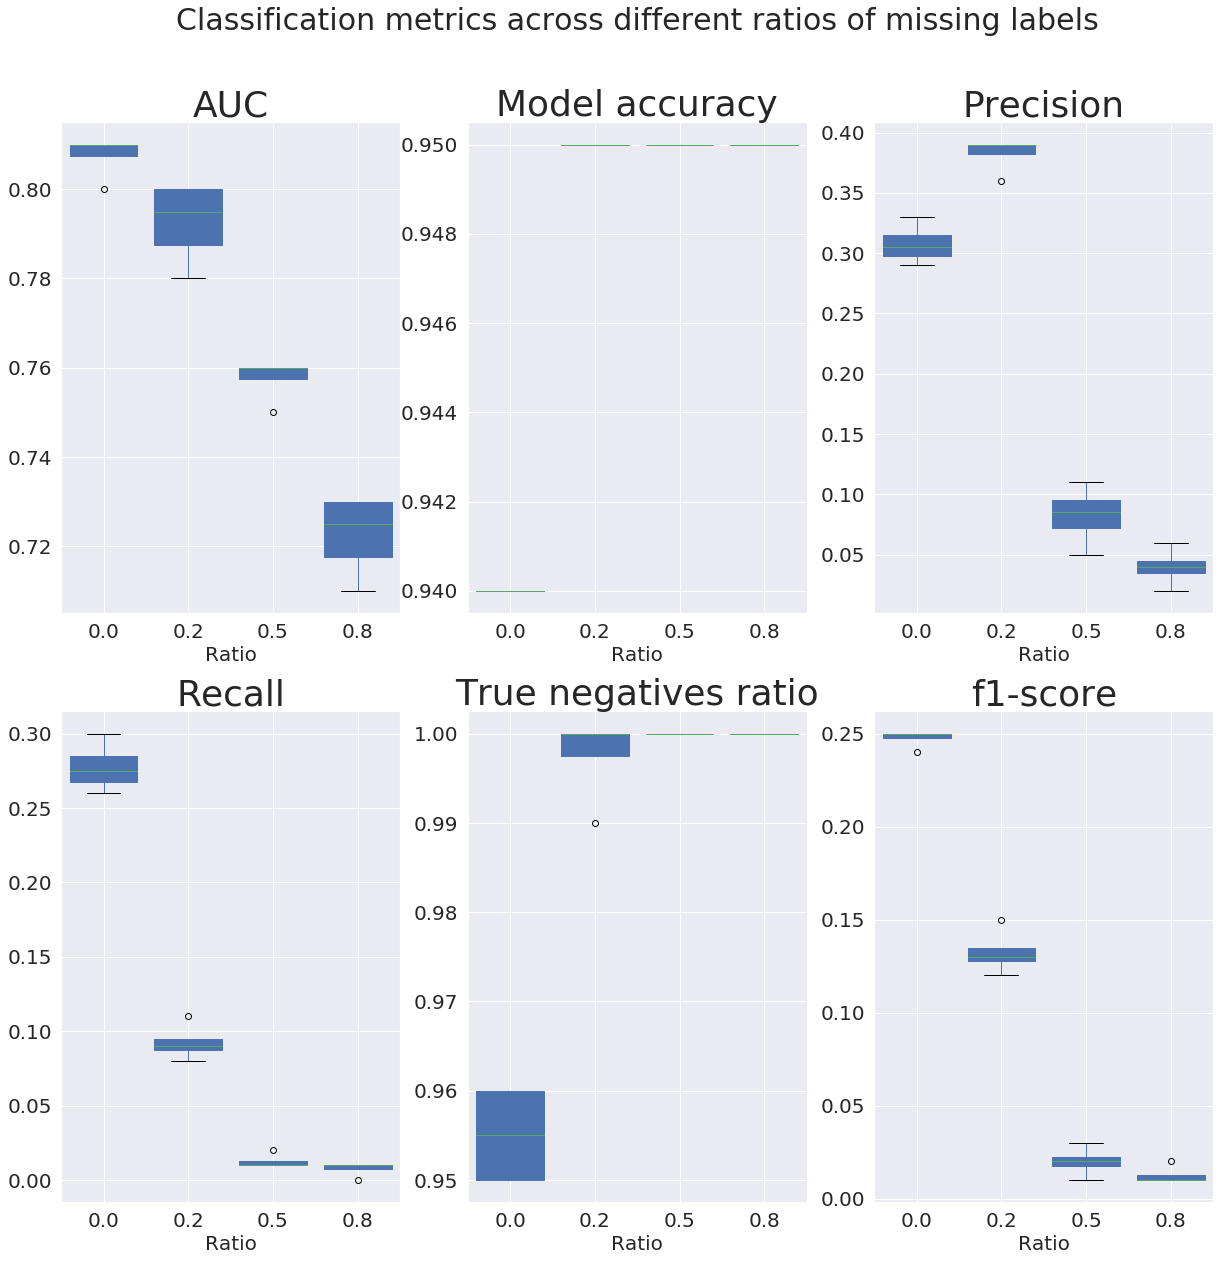

In [53]:
OCE_results_pd.drop(['Class','Kappa score','Ratio of positive samples','True positives ratio'],axis = 1,inplace=True)
OCE_results_pd.ratio = round(OCE_results_pd.ratio,1)
fig, ax_new = plt.subplots(2,3, sharey=False,figsize = [20,20])
OCE_results_pd.boxplot(by='ratio',fontsize = 20,ax=ax_new,  widths = 0.8, patch_artist = True)
fig.suptitle("Classification metrics across different ratios of missing labels", fontsize=30)                           
[x.set_xlabel('Ratio', fontsize = 20)for y in ax_new for x in y]

In [54]:
OUTPUT_PATH ="/srv/workspace/research/mlml/experiments_results_nus/"
weighted_CE_results_pd = pd.DataFrame()
for split in np.arange(1,5):
    for ratio in np.arange(0,1,0.25): 
        experiment_path = OUTPUT_PATH+'nus_3labels_weighted_CE'  + str(round(ratio, 1)) + 'split_' + str(split)
        dirs = os.listdir(experiment_path)
        split_ratio_results = pd.read_csv(experiment_path + '/' + dirs[0] + '/results_report.csv')
        split_ratio_results['ratio'] = ratio
        #split_ratio_results['split'] = split 
        split_ratio_results.rename(columns={"Unnamed: 0" : 'Class'},inplace=True)
        weighted_CE_results_pd = pd.concat([weighted_CE_results_pd,split_ratio_results[split_ratio_results.Class == 'average']])

[Text(0.5, 0, 'Ratio'),
 Text(0.5, 0, 'Ratio'),
 Text(0.5, 0, 'Ratio'),
 Text(0.5, 0, 'Ratio'),
 Text(0.5, 0, 'Ratio'),
 Text(0.5, 0, 'Ratio')]

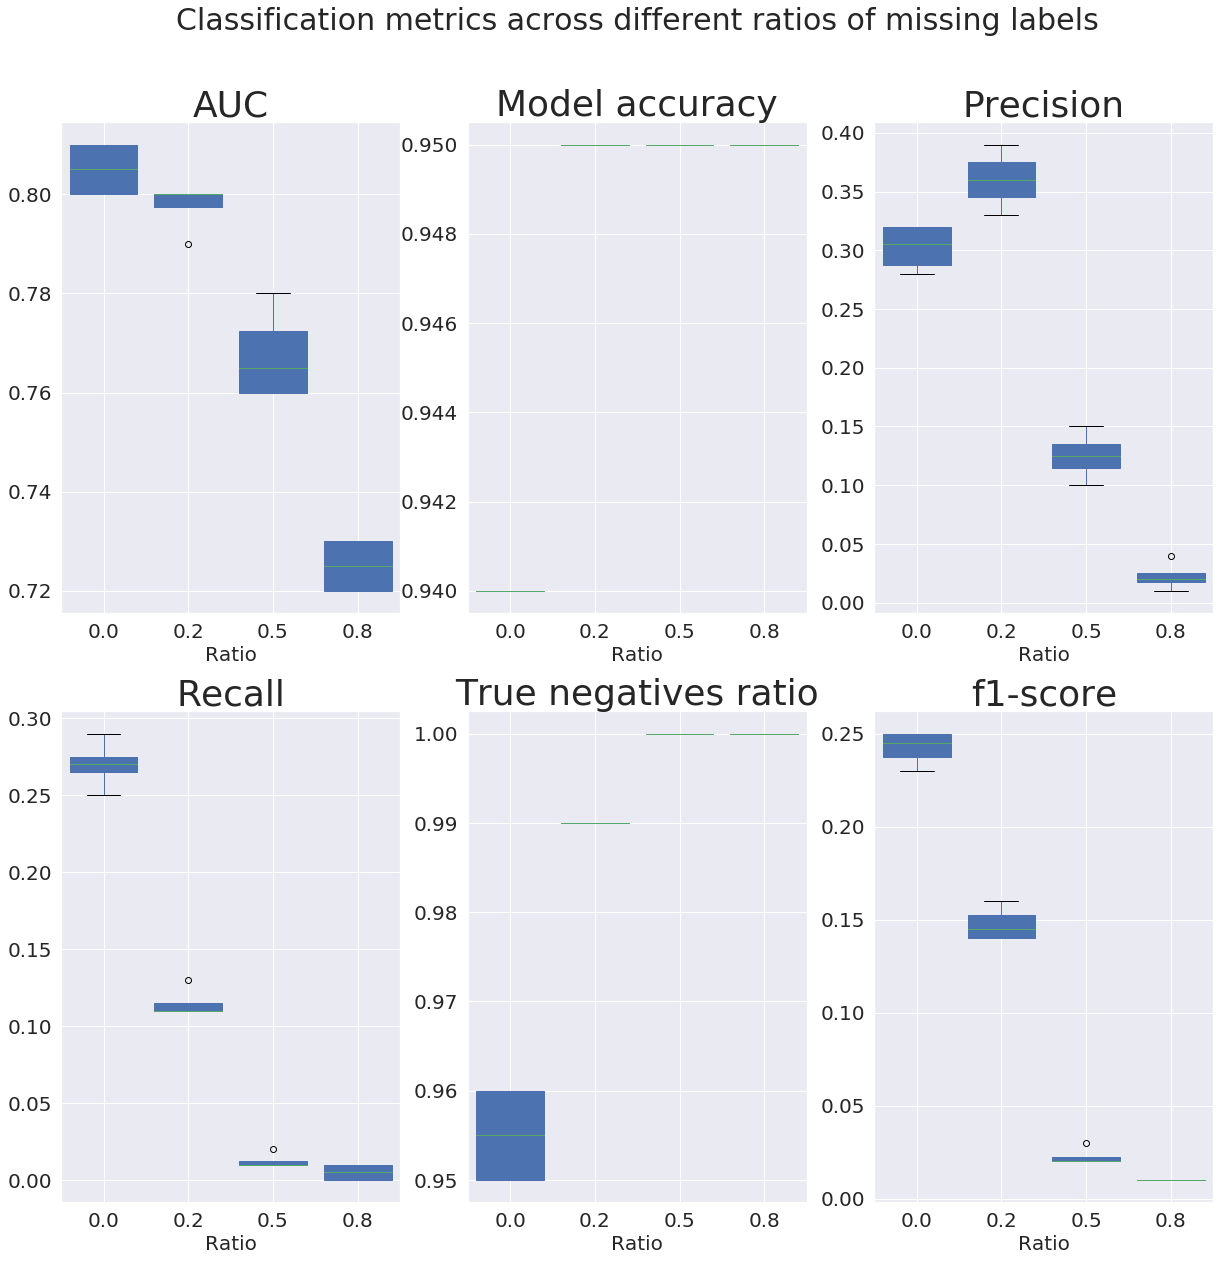

In [55]:
weighted_CE_results_pd.drop(['Class','Kappa score','Ratio of positive samples','True positives ratio'],axis = 1,inplace=True)
weighted_CE_results_pd.ratio = round(weighted_CE_results_pd.ratio,1)
fig, ax_new = plt.subplots(2,3, sharey=False,figsize = [20,20])
weighted_CE_results_pd.boxplot(by='ratio',fontsize = 20,ax=ax_new,  widths = 0.8, patch_artist = True)
fig.suptitle("Classification metrics across different ratios of missing labels", fontsize=30)                           
[x.set_xlabel('Ratio', fontsize = 20)for y in ax_new for x in y]

In [56]:
OCE_results_pd['method'] = 'CE'
weighted_CE_results_pd['method'] = 'Weighted CE'


In [57]:
all_results = pd.concat([OCE_results_pd,weighted_CE_results_pd])

Text(0.5, 0.98, 'Classification metrics across different ratios of missing labels')

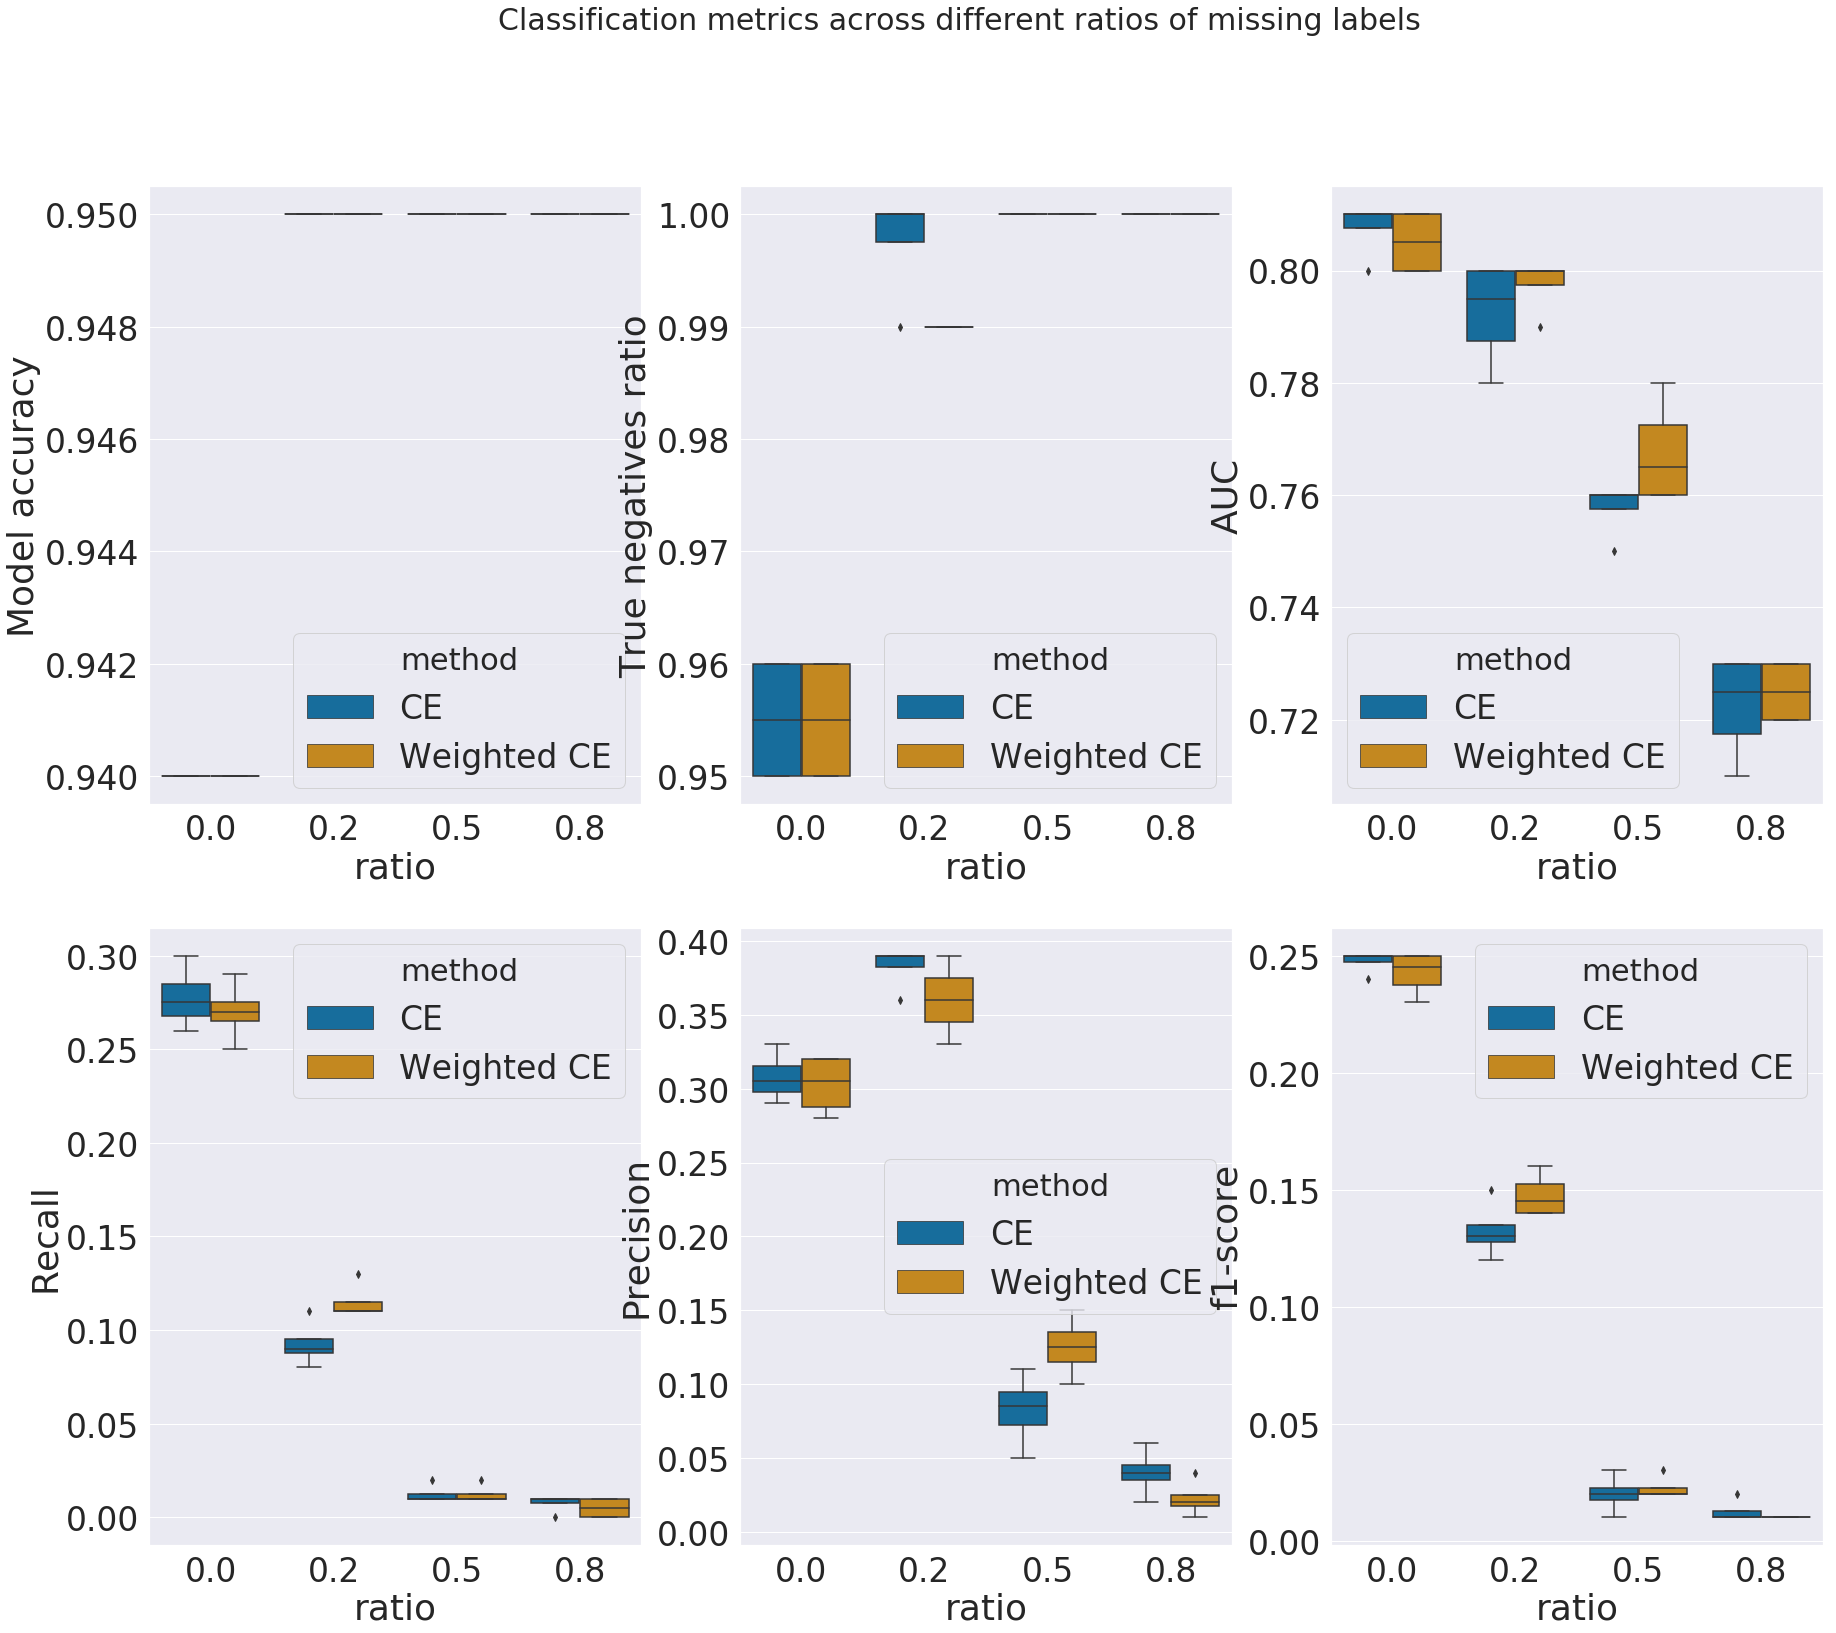

In [58]:
fig, ax_new = plt.subplots(2,3, sharey=False,figsize = [30,25])
columns_To_plot = all_results.columns[:-2]
for column, plot_column in zip(columns_To_plot,ax_new.flatten()):
    sn.boxplot(y=column, x='ratio', 
                     data=all_results, 
                     palette="colorblind",
                     hue='method',ax =plot_column)
fig.suptitle("Classification metrics across different ratios of missing labels", fontsize=30)                           
#[x.set_xlabel('Ratio', fontsize = 20)for y in ax_new for x in y]


## threshold optimization

In [94]:
labels_names_dir = "/srv/workspace/research/mlml/datasets/nuswide/tags/Concepts81.txt"
LABELS_LIST =  np.asarray([line.rstrip('\n') for line in open(labels_names_dir)])

In [60]:
def create_optimized_results_report(experiment_path,VALIDATION_SIZE = 1000):
    model_output= np.loadtxt(os.path.join(experiment_path , "predictions.out"),delimiter=',')
    model_output_rounded = np.round(model_output)
    groundtruth = np.loadtxt(os.path.join(experiment_path , "test_ground_truth_classes.txt"),delimiter=',')
    results_df = pd.read_csv(os.path.join(experiment_path , "results_report.csv"),index_col = 0)
    results_df.drop('average',axis = 0, inplace = True)
    results_df = results_df.T

    validation_output = model_output[:VALIDATION_SIZE]
    validation_groundtruth = groundtruth[:VALIDATION_SIZE]

    model_output = model_output[VALIDATION_SIZE:]
    groundtruth = groundtruth[VALIDATION_SIZE:]

    thresholds = np.arange(0, 1, 0.01)
    f1_array = np.zeros((len(LABELS_LIST), len(thresholds)))
    for idx, label in enumerate(LABELS_LIST):
        f1_array[idx, :] = [
            f1_score(validation_groundtruth[:, idx], np.clip(np.round(validation_output[:, idx] - threshold + 0.5), 0, 1))
            for threshold in thresholds]
    threshold_arg = np.argmax(f1_array, axis=1)
    threshold_per_class = thresholds[threshold_arg]

    # plot the f1 score across thresholds
    plt.figure(figsize=(20, 20))
    for idx, x in enumerate(LABELS_LIST):
        plt.plot(thresholds, f1_array[idx, :], linewidth=5)
    plt.legend(LABELS_LIST, loc='best')
    plt.title("F1 Score vs different prediction threshold values for each class")
    #plt.savefig(os.path.join(output_path, "f1_score_vs_thresholds.pdf"), format="pdf")
    #plt.savefig(os.path.join(output_path, "f1_score_vs_thresholds.png"))

    # Applying thresholds optimized per class
    model_output_rounded = np.zeros_like(model_output)
    for idx, label in enumerate(LABELS_LIST):
        model_output_rounded[:, idx] = np.clip(np.round(model_output[:, idx] - threshold_per_class[idx] + 0.5), 0, 1)

    accuracies_perclass = sum(model_output_rounded == groundtruth) / len(groundtruth)
    # Getting the true positive rate perclass
    true_positives_ratio_perclass = sum((model_output_rounded == groundtruth) * (groundtruth == 1)) / sum(
        groundtruth)
    # Get true negative ratio
    true_negative_ratio_perclass = sum((model_output_rounded == groundtruth)
                                       * (groundtruth == 0)) / (len(groundtruth) - sum(groundtruth))
    results_df = results_df.append(
        pd.DataFrame([accuracies_perclass, true_positives_ratio_perclass,
                      true_negative_ratio_perclass], columns=LABELS_LIST))
    # compute additional metrics (AUC,f1,recall,precision)
    auc_roc_per_label = roc_auc_score(groundtruth, model_output, average=None)
    precision_perlabel = precision_score(groundtruth, model_output_rounded, average=None)
    recall_perlabel = recall_score(groundtruth, model_output_rounded, average=None)
    f1_perlabel = f1_score(groundtruth, model_output_rounded, average=None)
    kappa_perlabel = [cohen_kappa_score(groundtruth[:, x], model_output_rounded[:, x]) for x in
                      range(len(LABELS_LIST))]
    results_df = results_df.append(
        pd.DataFrame([auc_roc_per_label, recall_perlabel, precision_perlabel, f1_perlabel,kappa_perlabel],
                     columns=LABELS_LIST))
    results_df.index = ['Ratio of positive samples', 'Model accuracy', 'True positives ratio',
                        'True negatives ratio', "AUC", "Precision", "Recall", "f1-score",  "Kappa score",
                        'Optimized model accuracy', 'Optimized true positives ratio',
                        'Optimized true negatives ratio', "Optimized AUC",
                        "Optimized recall", "Optimized precision", "Optimized f1-score",  "Optimized Kappa score"]

    # Creating evaluation plots
    plot_true_poisitve_vs_all_positives(model_output_rounded, groundtruth,
                                        os.path.join(experiment_path, 'TruePositive_vs_allPositives[optimized]'),
                                        LABELS_LIST)
    #plot_output_coocurances(model_output_rounded, os.path.join(experiment_path, 'output_coocurances[optimized]'),
    #                        LABELS_LIST)
    #plot_false_netgatives_confusion_matrix(model_output_rounded, groundtruth,
    #                                       os.path.join(experiment_path, 'false_negative_coocurances[optimized]'),
    #                                       LABELS_LIST)
    results_df['average'] = results_df.mean(numeric_only=True, axis=1)
    results_df.T.to_csv(os.path.join(experiment_path, "results_report_optimized.csv"), float_format="%.2f")
    return results_df.T

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Ratio of positive samples  Model accuracy  \
person                          0.720000           0.280   
bicycle                         0.070000           0.930   
car                             0.200000           0.820   
motorcycle                      0.040000           0.960   
airplane                        0.010000           0.990   
bus                             0.060000           0.950   
train                           0.020000           0.990   
truck                           0.100000           0.900   
boat                            0.020000           0.980   
traffic light                   0.070000           0.940   
fire hydrant                    0.020000           0.980   
stop sign                       0.020000           0.980   
parking meter                   0.010000           0.990   
bench                           0.090000           0.910   
bird                            0.010000           0.990   
cat                             0.030000           0.970   
dog                             0.050000           0.960   
horse                           0.020000           0.980   
sheep                           0.000000           1.000   
cow                             0.010000           0.990   
elephant                        0.010000           1.000   
bear                            0.000000           1.000   
zebra                           0.000000           1.000   
giraffe                         0.000000           1.000   
backpack                        0.120000           0.880   
umbrella                        0.070000           0.930   
handbag                         0.160000           0.840   
tie                             0.050000           0.950   
suitcase                        0.040000           0.960   
frisbee                         0.010000           0.990   
...                                  ...             ...   
carrot                          0.030000           0.970   
hot dog                         0.020000           0.980   
pizza                           0.050000           0.960   
donut                           0.020000           0.980   
cake                            0.060000           0.940   
chair                           0.300000           0.700   
couch                           0.100000           0.900   
potted plant                    0.100000           0.900   
bed                             0.040000           0.960   
dining table                    0.290000           0.730   
toilet                          0.010000           0.990   
tv                              0.110000           0.900   
laptop                          0.080000           0.940   
mouse                           0.040000           0.970   
remote                          0.060000           0.940   
keyboard                        0.040000           0.970   
cell phone                      0.090000           0.910   
microwave                       0.040000           0.960   
oven                            0.060000           0.950   
toaster                         0.010000           0.990   
sink                            0.070000           0.940   
refrigerator                    0.050000           0.940   
book                            0.120000           0.880   
clock                           0.060000           0.940   
vase                            0.070000           0.930   
scissors                        0.010000           0.990   
teddy bear                      0.020000           0.980   
hair drier                      0.000000           1.000   
toothbrush                      0.010000           0.990   
average                         0.066625           0.936   

               True positives ratio  True negatives ratio   AUC  Precision  \
person                     0.000000                 1.000  0.77   0.000000   
bicycle                    0.010000                 1.000  0.83   0.010000   
car                        0.120000                 0.990  0

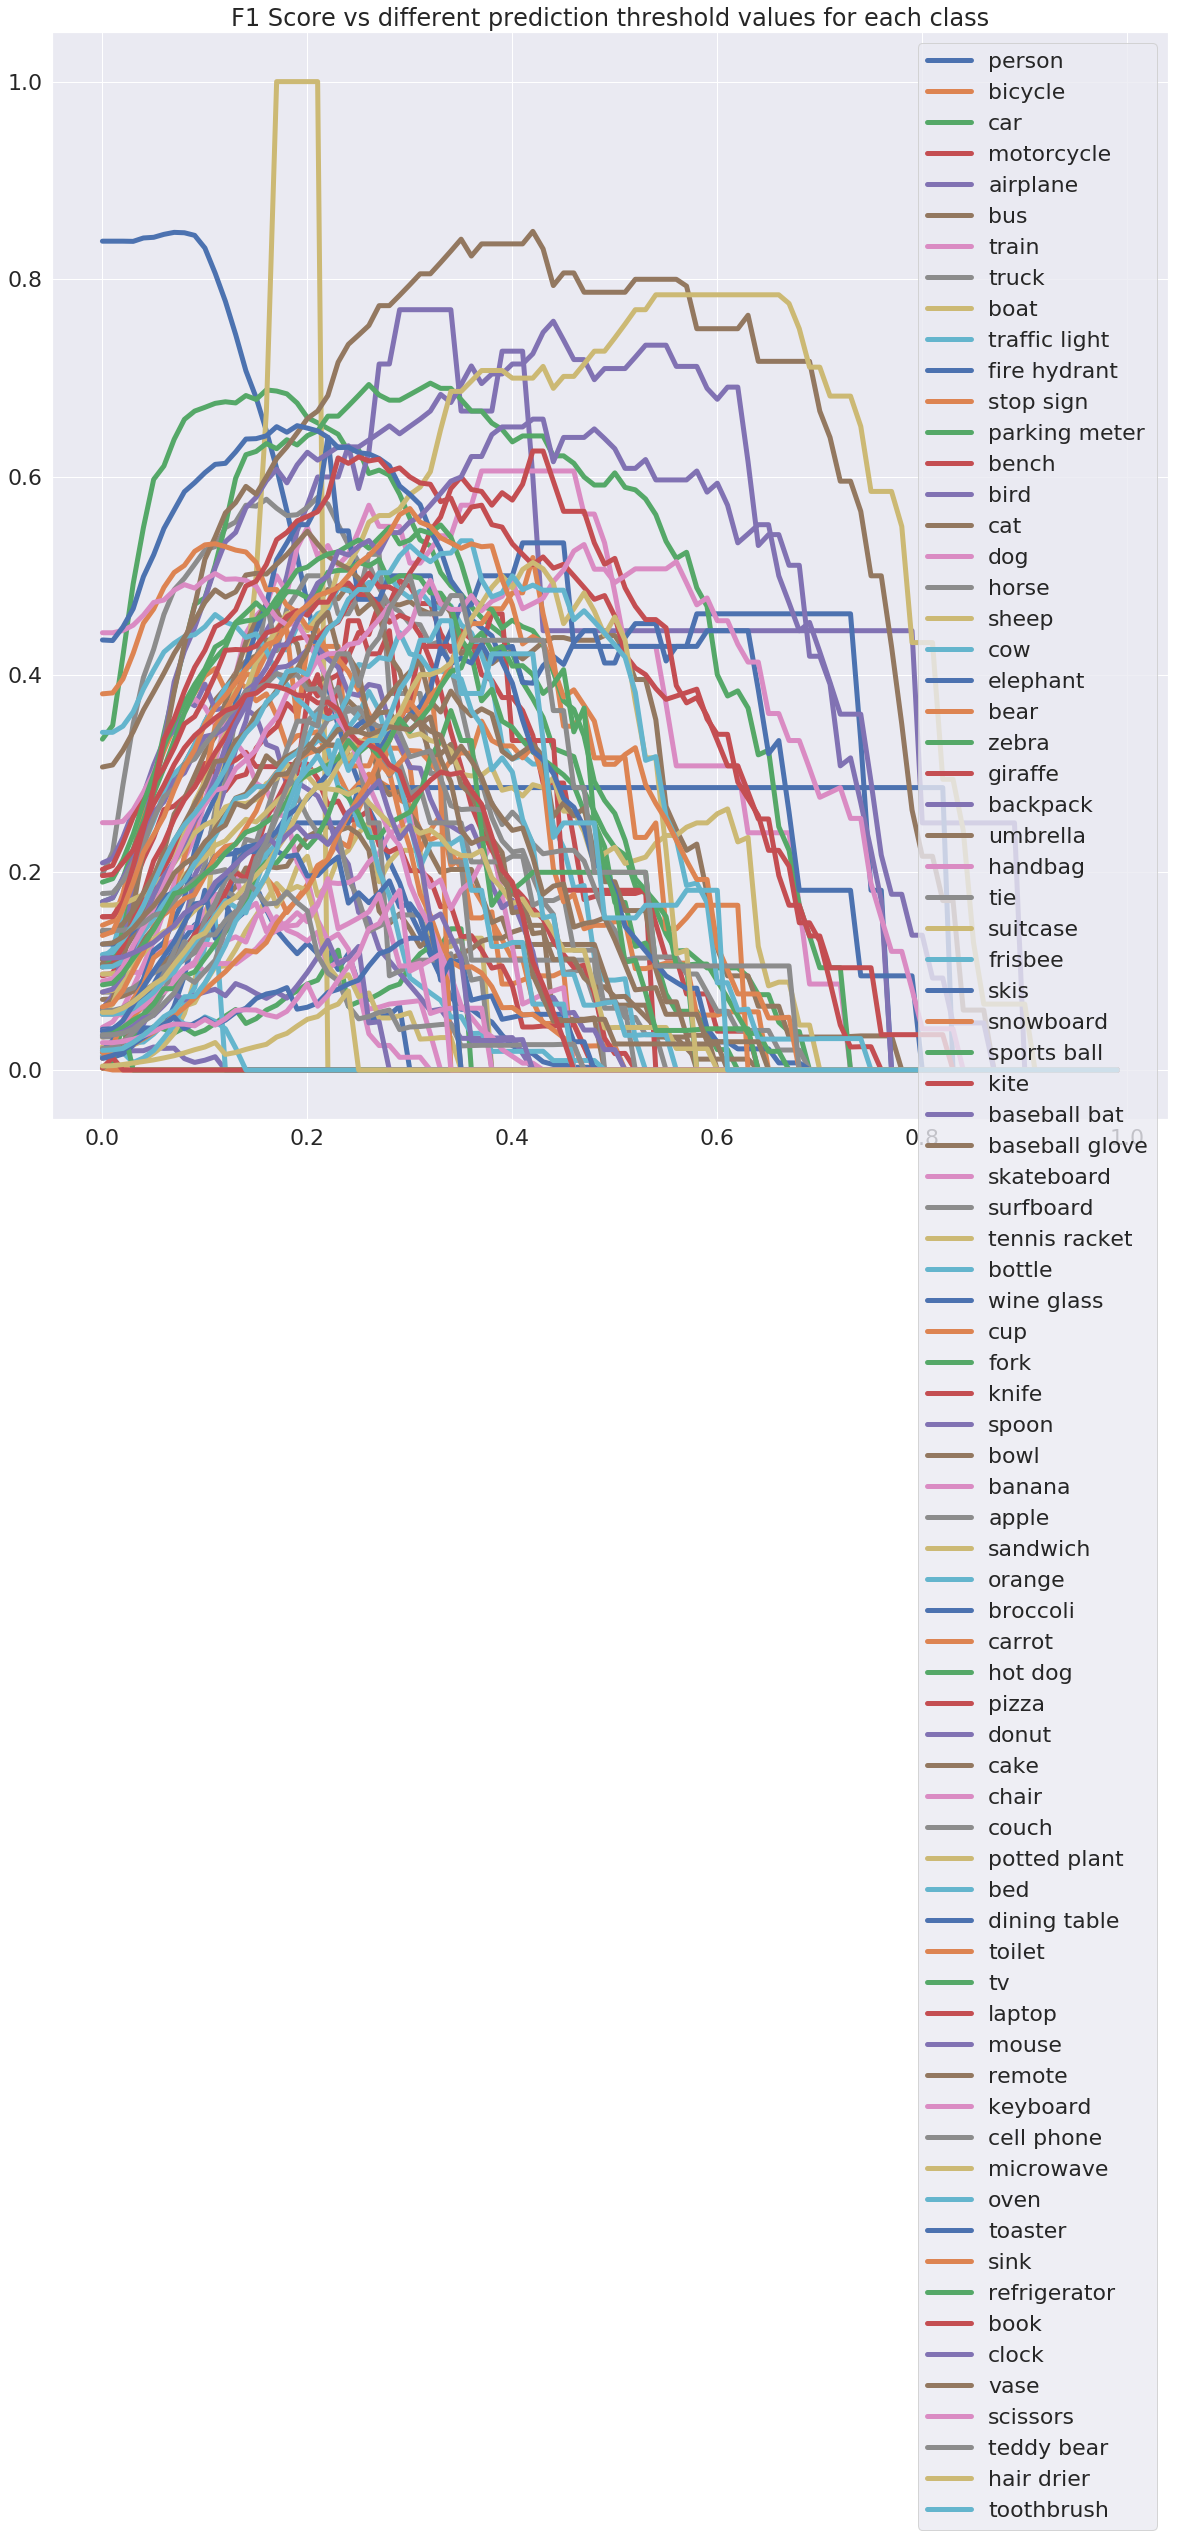

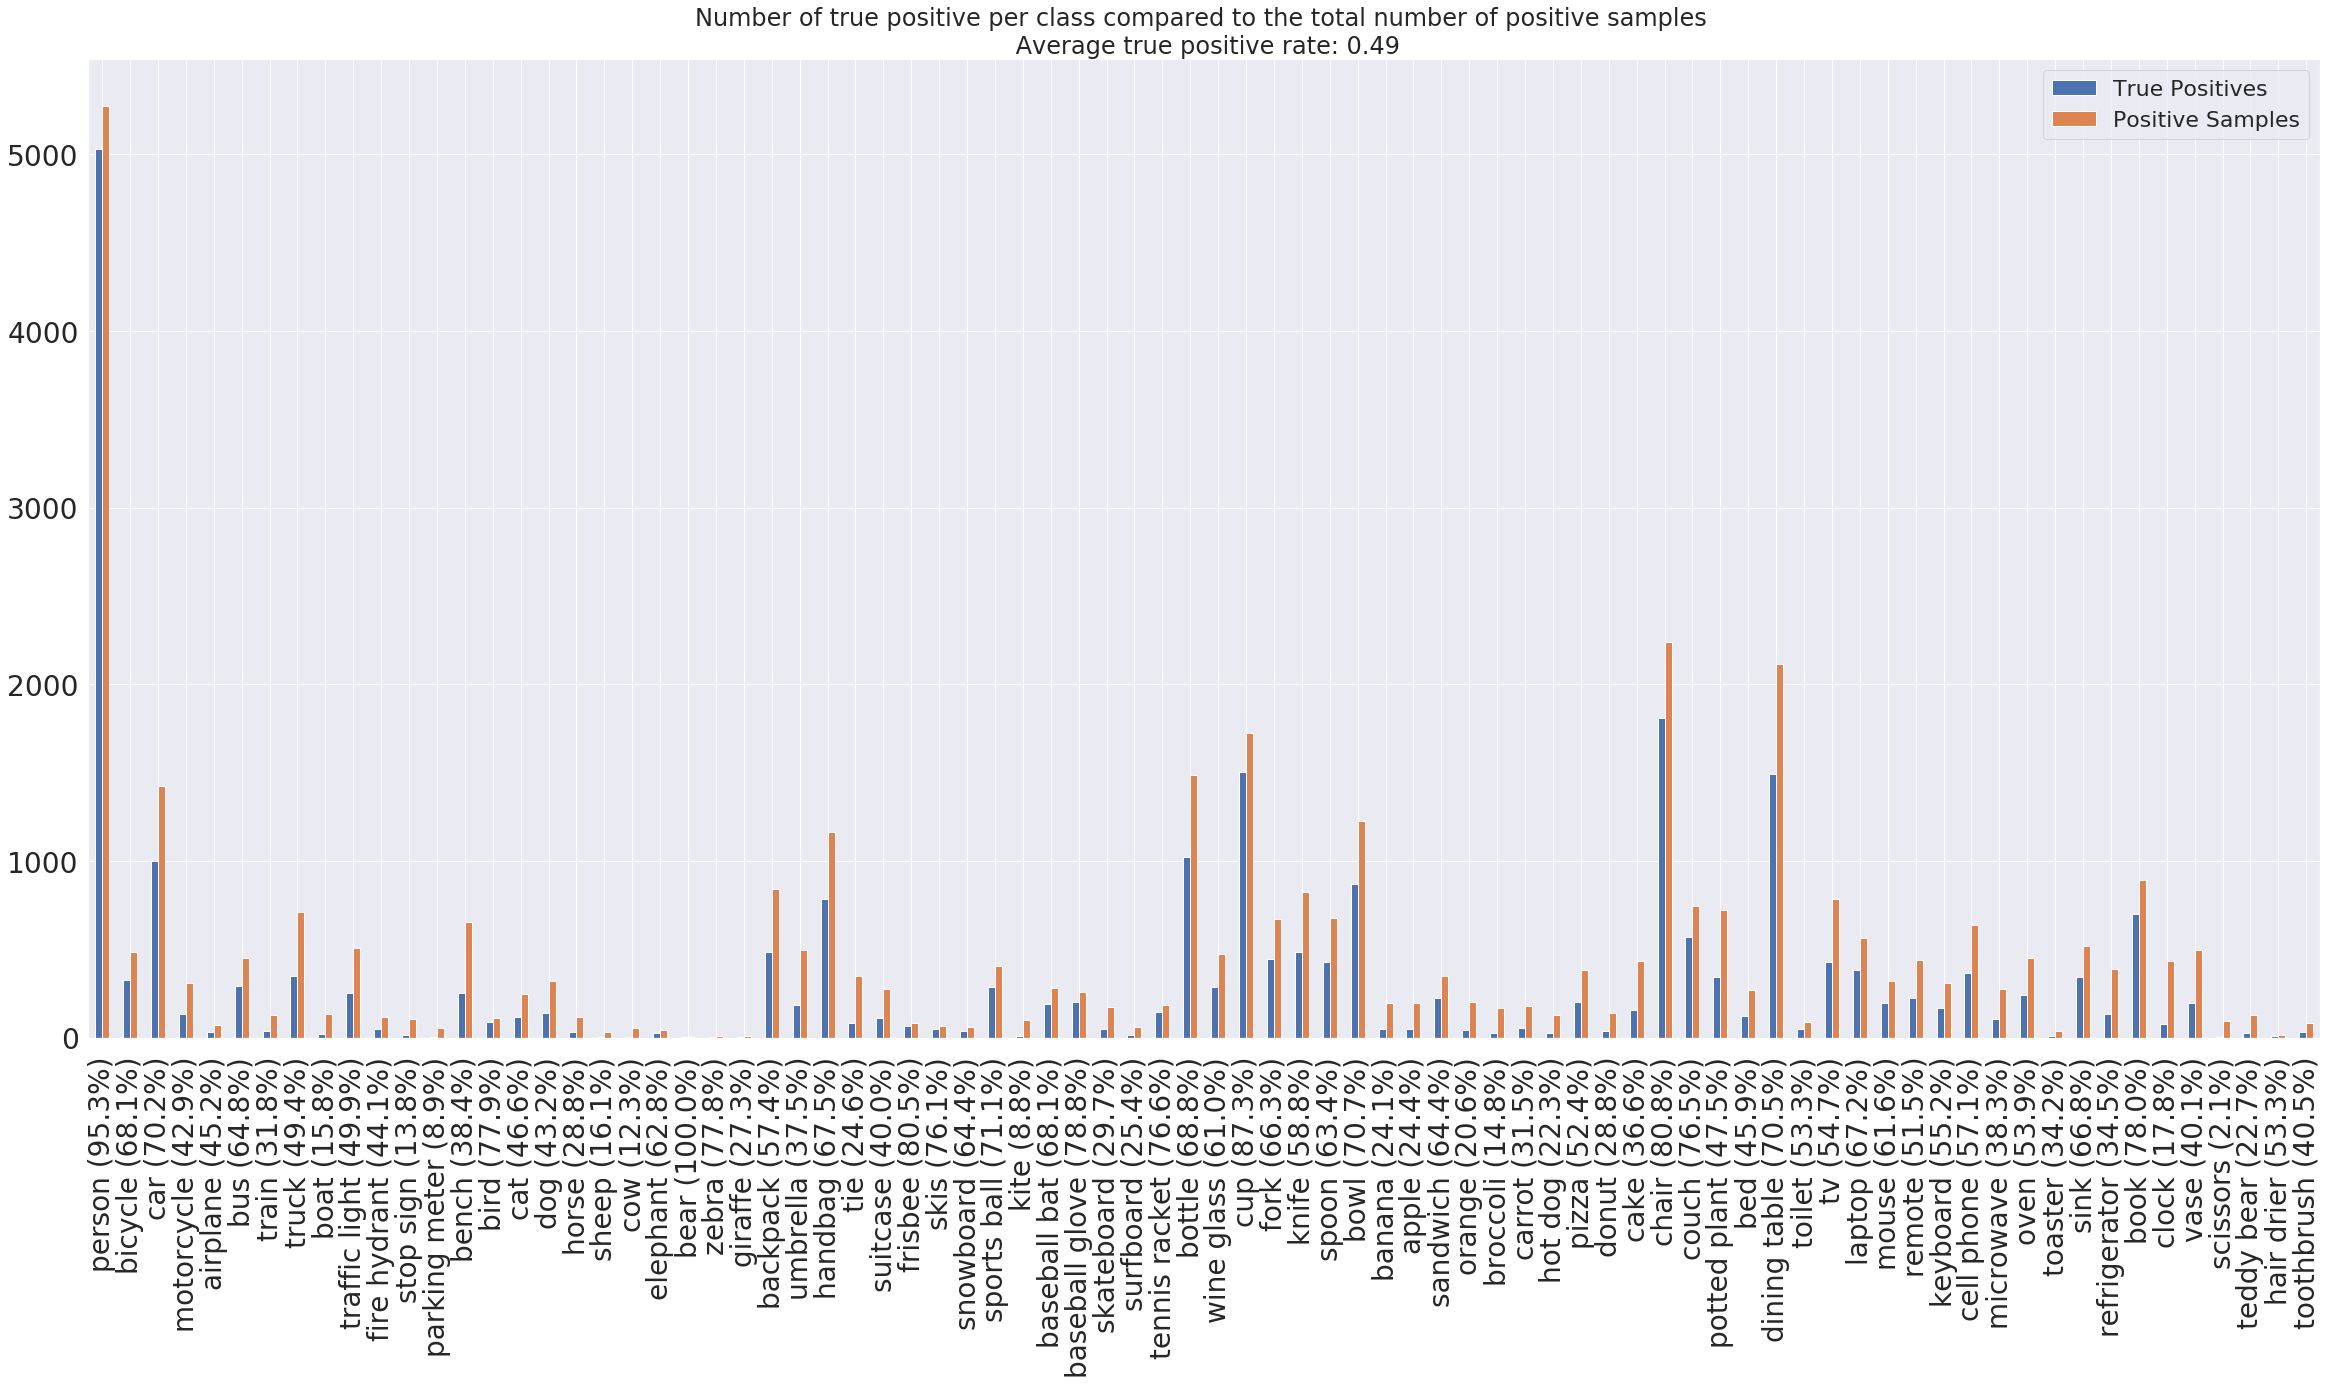

In [92]:
create_optimized_results_report("/srv/workspace/research/mlml/experiments_results_balanced/resnet_original_CE_balanced_ratio0.8split_1/18-12_18-48/")

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Ratio of positive samples  Model accuracy  \
person                          0.720000           0.640   
bicycle                         0.070000           0.930   
car                             0.200000           0.860   
motorcycle                      0.040000           0.960   
airplane                        0.010000           0.990   
bus                             0.060000           0.950   
train                           0.020000           0.990   
truck                           0.100000           0.900   
boat                            0.020000           0.980   
traffic light                   0.070000           0.930   
fire hydrant                    0.020000           0.980   
stop sign                       0.020000           0.980   
parking meter                   0.010000           0.990   
bench                           0.090000           0.910   
bird                            0.010000           0.990   
cat                             0.030000           0.970   
dog                             0.050000           0.950   
horse                           0.020000           0.990   
sheep                           0.000000           1.000   
cow                             0.010000           0.990   
elephant                        0.010000           1.000   
bear                            0.000000           1.000   
zebra                           0.000000           1.000   
giraffe                         0.000000           1.000   
backpack                        0.120000           0.880   
umbrella                        0.070000           0.940   
handbag                         0.160000           0.840   
tie                             0.050000           0.950   
suitcase                        0.040000           0.960   
frisbee                         0.010000           0.990   
...                                  ...             ...   
carrot                          0.030000           0.970   
hot dog                         0.020000           0.980   
pizza                           0.050000           0.960   
donut                           0.020000           0.980   
cake                            0.060000           0.940   
chair                           0.300000           0.700   
couch                           0.100000           0.910   
potted plant                    0.100000           0.900   
bed                             0.040000           0.960   
dining table                    0.290000           0.810   
toilet                          0.010000           0.990   
tv                              0.110000           0.920   
laptop                          0.080000           0.940   
mouse                           0.040000           0.970   
remote                          0.060000           0.930   
keyboard                        0.040000           0.960   
cell phone                      0.090000           0.910   
microwave                       0.040000           0.950   
oven                            0.060000           0.950   
toaster                         0.010000           0.990   
sink                            0.070000           0.950   
refrigerator                    0.050000           0.940   
book                            0.120000           0.880   
clock                           0.060000           0.940   
vase                            0.070000           0.930   
scissors                        0.010000           0.990   
teddy bear                      0.020000           0.980   
hair drier                      0.000000           1.000   
toothbrush                      0.010000           0.990   
average                         0.066625           0.942   

               True positives ratio  True negatives ratio       AUC  \
person                     0.530000                  0.94  0.840000   
bicycle                    0.170000                  0.99  0.850000   
car                        0.370000                  0.97  0.890000   
motorcycle

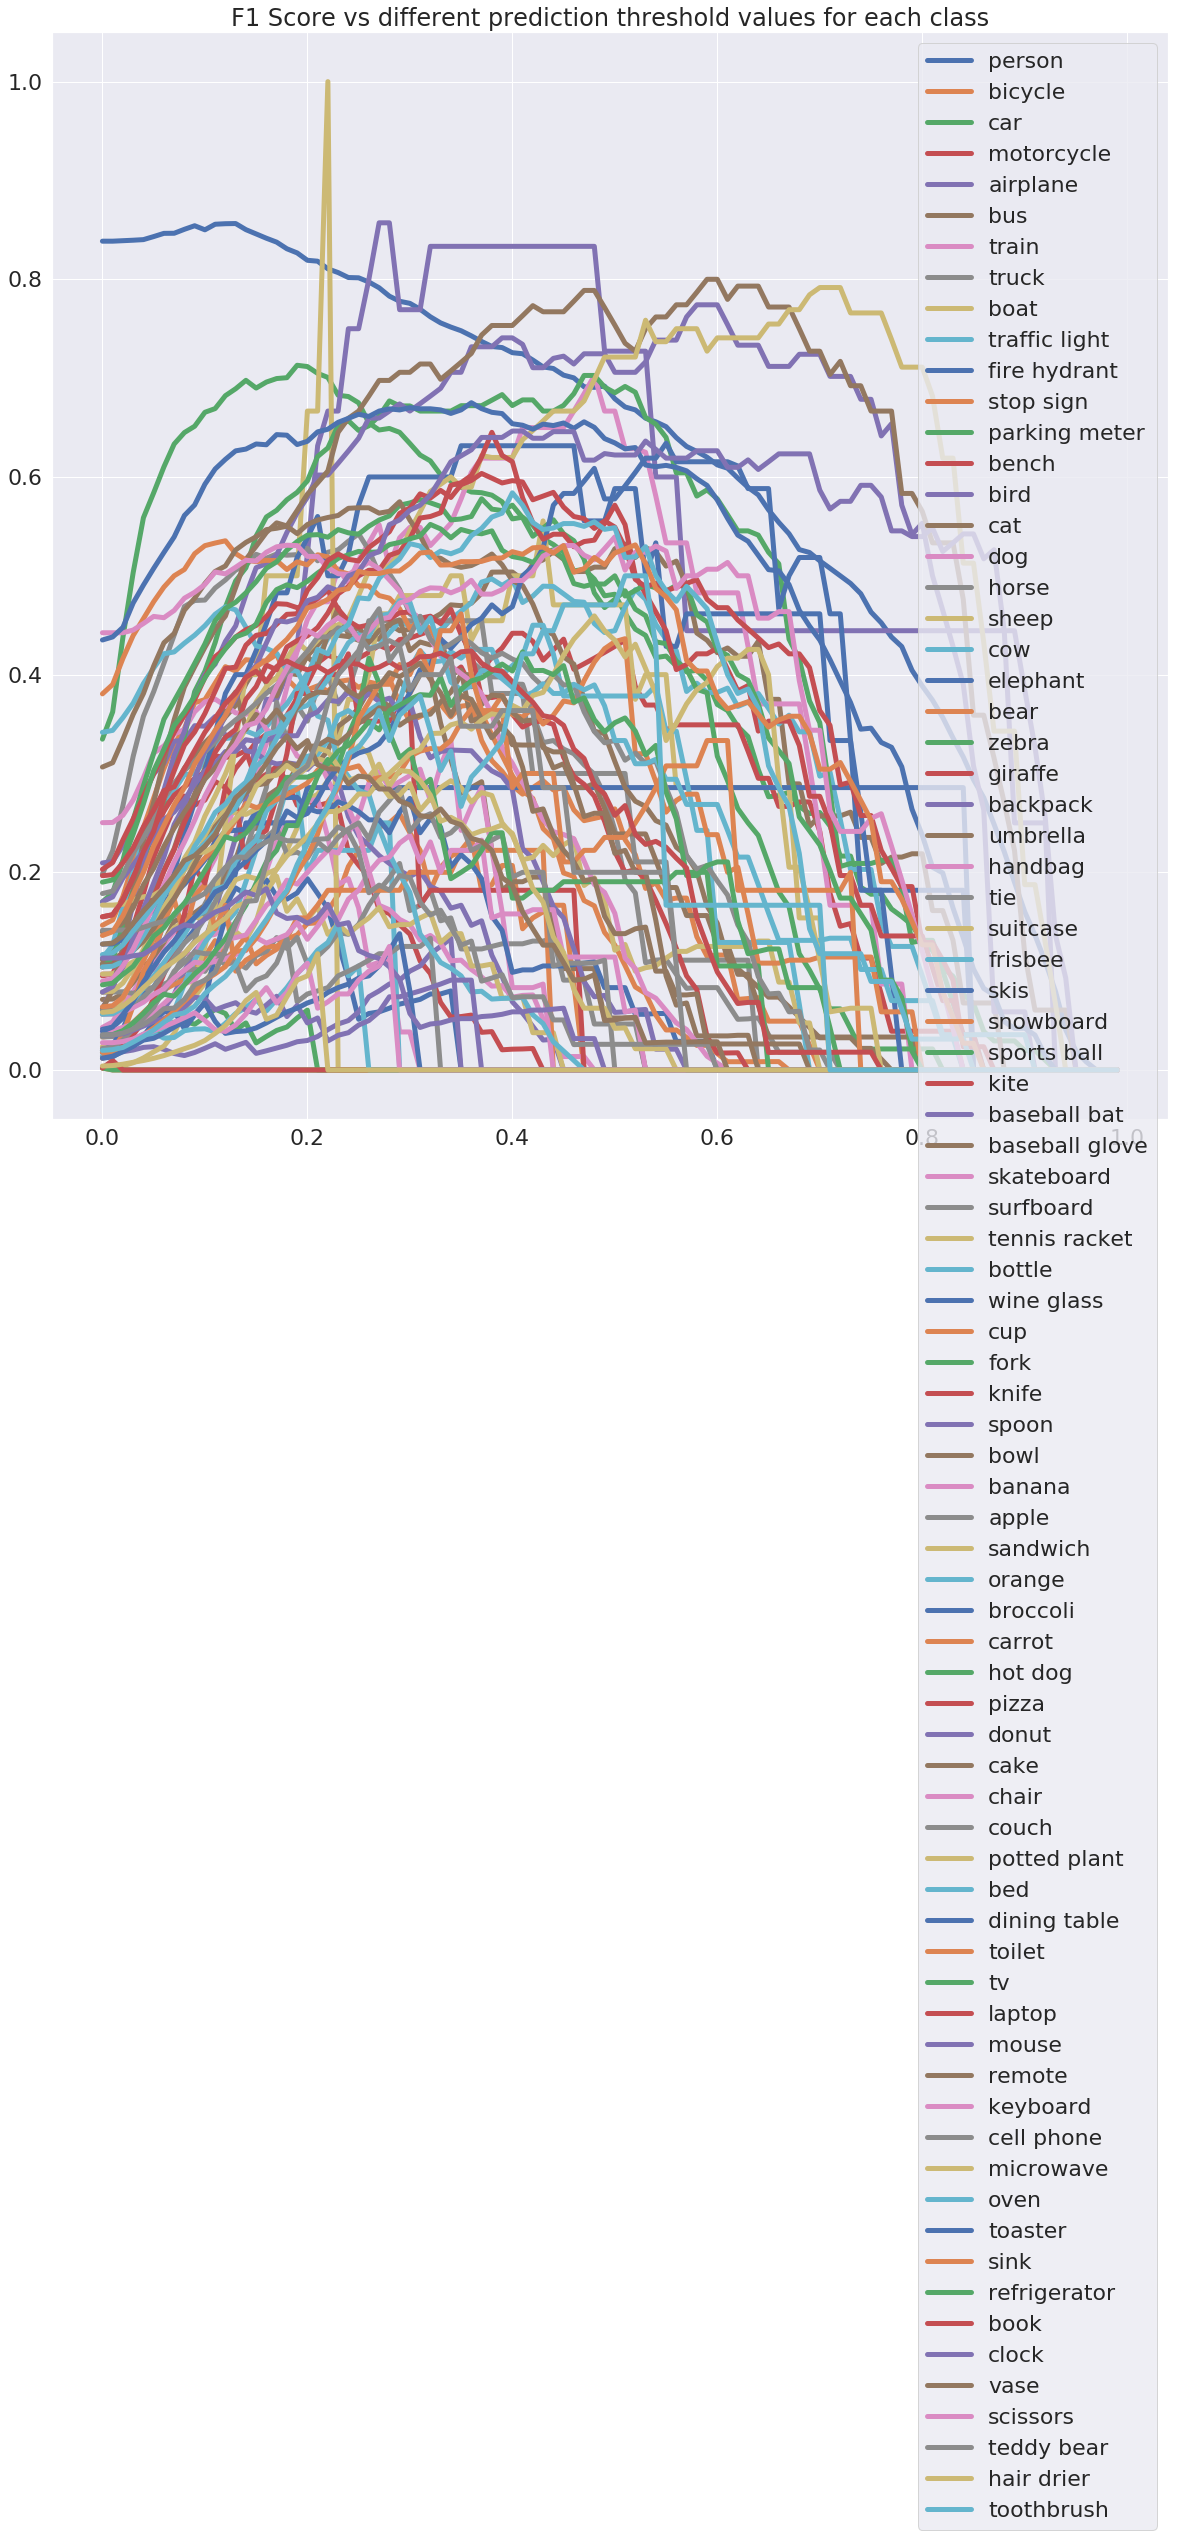

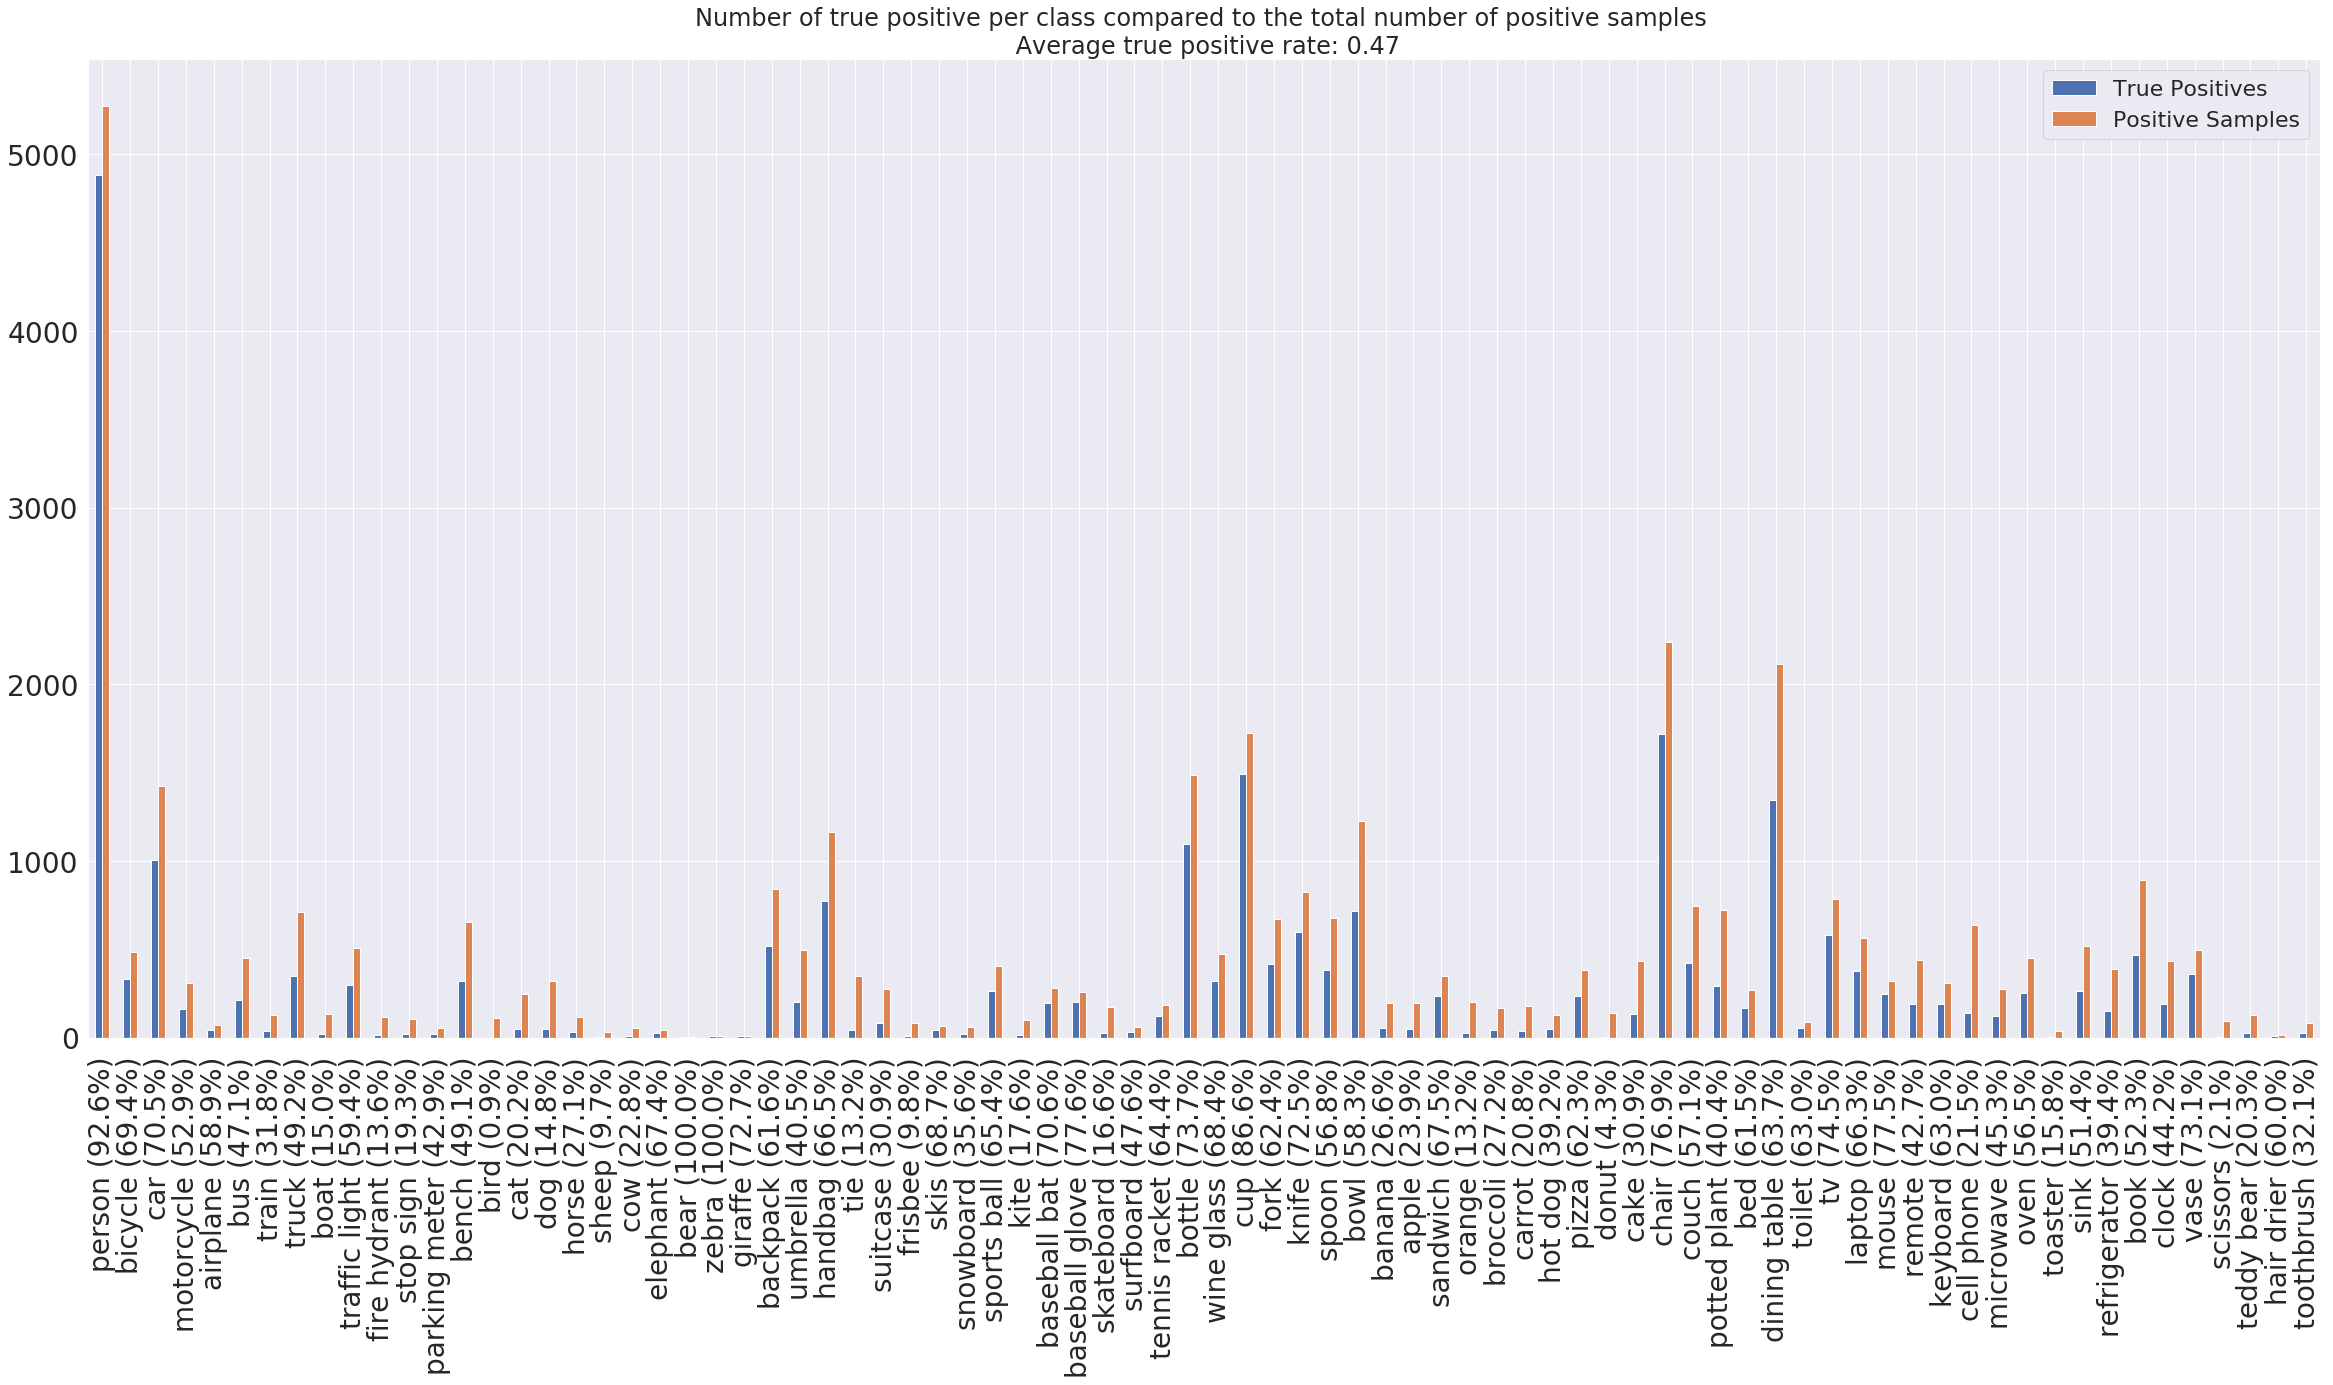

In [93]:
create_optimized_results_report("/srv/workspace/research/mlml/experiments_results_balanced/resnet_weighted_CE_balanced_ratio0.8split_1/18-12_19-05/")

In [61]:
OUTPUT_PATH ="/srv/workspace/research/mlml/experiments_results_nus/"
correlation_CE_results_pd = pd.DataFrame()
for split in np.arange(1,5):
    for ratio in np.arange(0,1,0.25): 
        experiment_path = OUTPUT_PATH+'nus_3labels_correlations_CE'  + str(round(ratio, 1)) + 'split_' + str(split)
        dirs = os.listdir(experiment_path)
        split_ratio_results = pd.read_csv(experiment_path + '/' + dirs[0] + '/results_report.csv')
        split_ratio_results['ratio'] = ratio
        #split_ratio_results['split'] = split 
        split_ratio_results.rename(columns={"Unnamed: 0" : 'Class'},inplace=True)
        correlation_CE_results_pd = pd.concat([correlation_CE_results_pd,split_ratio_results[split_ratio_results.Class == 'average']])

[Text(0.5, 0, 'Ratio'),
 Text(0.5, 0, 'Ratio'),
 Text(0.5, 0, 'Ratio'),
 Text(0.5, 0, 'Ratio'),
 Text(0.5, 0, 'Ratio'),
 Text(0.5, 0, 'Ratio')]

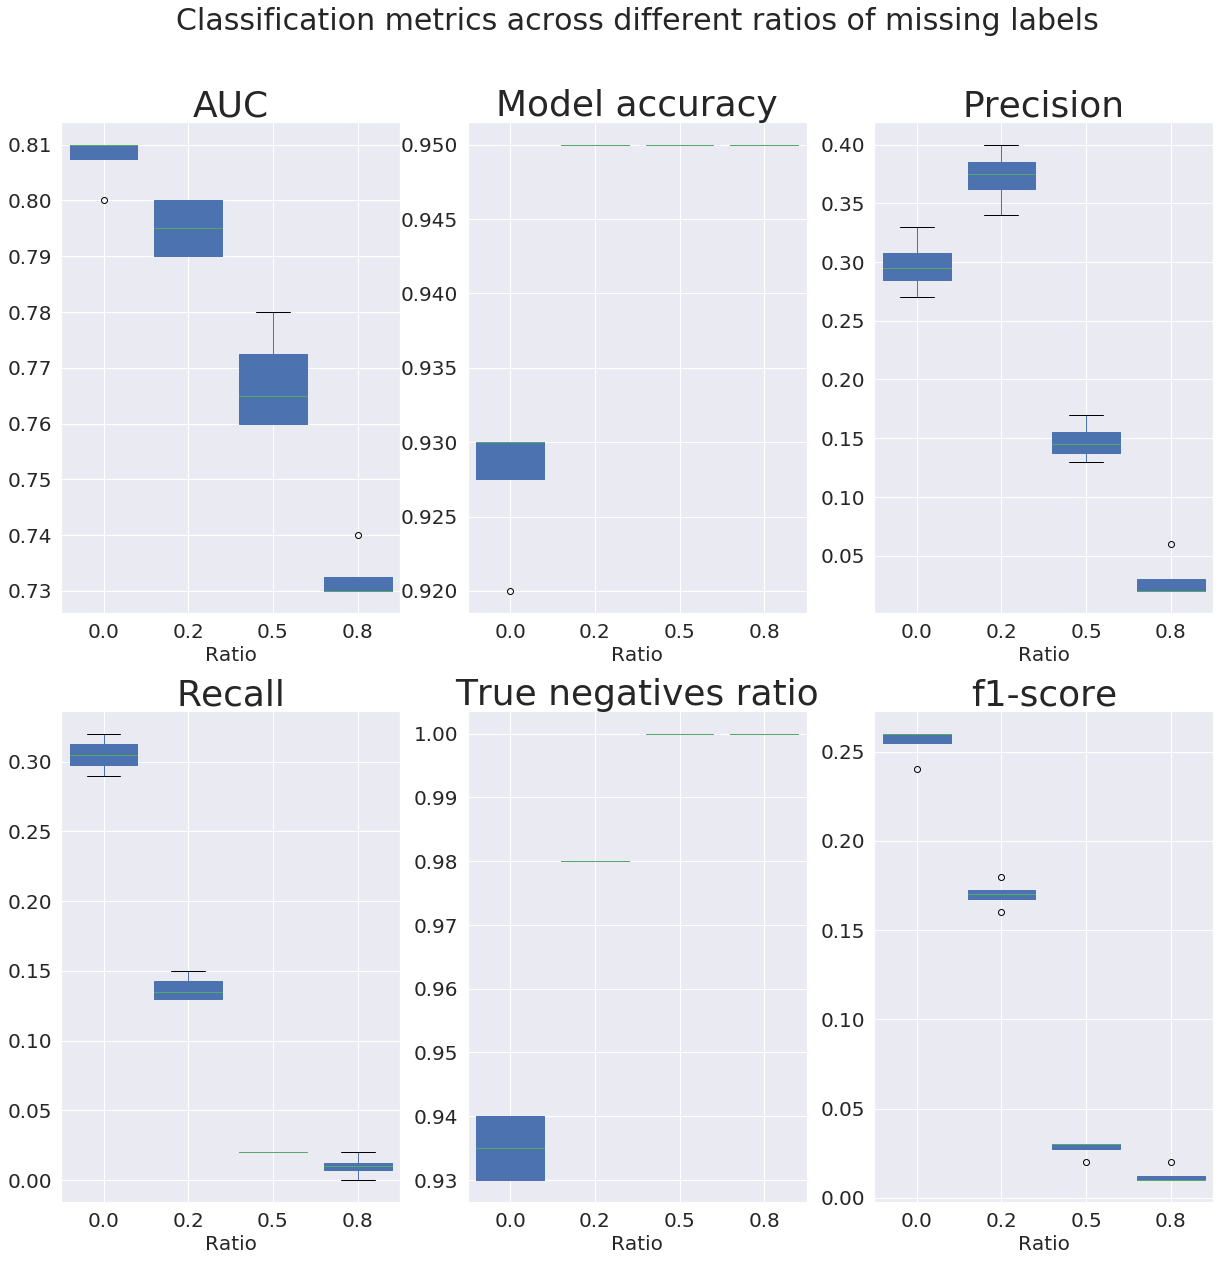

In [62]:
correlation_CE_results_pd.drop(['Class','Kappa score','Ratio of positive samples','True positives ratio'],axis = 1,inplace=True)
correlation_CE_results_pd.ratio = round(weighted_CE_results_pd.ratio,1)
fig, ax_new = plt.subplots(2,3, sharey=False,figsize = [20,20])
correlation_CE_results_pd.boxplot(by='ratio',fontsize = 20,ax=ax_new,  widths = 0.8, patch_artist = True)
fig.suptitle("Classification metrics across different ratios of missing labels", fontsize=30)                           
[x.set_xlabel('Ratio', fontsize = 20)for y in ax_new for x in y]

In [63]:
OCE_results_pd['method'] = 'CE'
correlation_CE_results_pd['method'] = 'CW-CE'
all_results = pd.concat([all_results,correlation_CE_results_pd])

In [64]:
all_results.ratio[all_results.ratio == 0.8] = 0.75 
all_results.ratio[all_results.ratio == 0.2] = 0.25 
all_results.method[all_results.method == 'Weighted CE'] = 'EW-CE'

all_results.drop(['Model accuracy' ,'True negatives ratio' , 'AUC'], axis = 1,inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0.98, 'Classification metrics across different ratios of missing labels on the NUS-WIDE dataset')

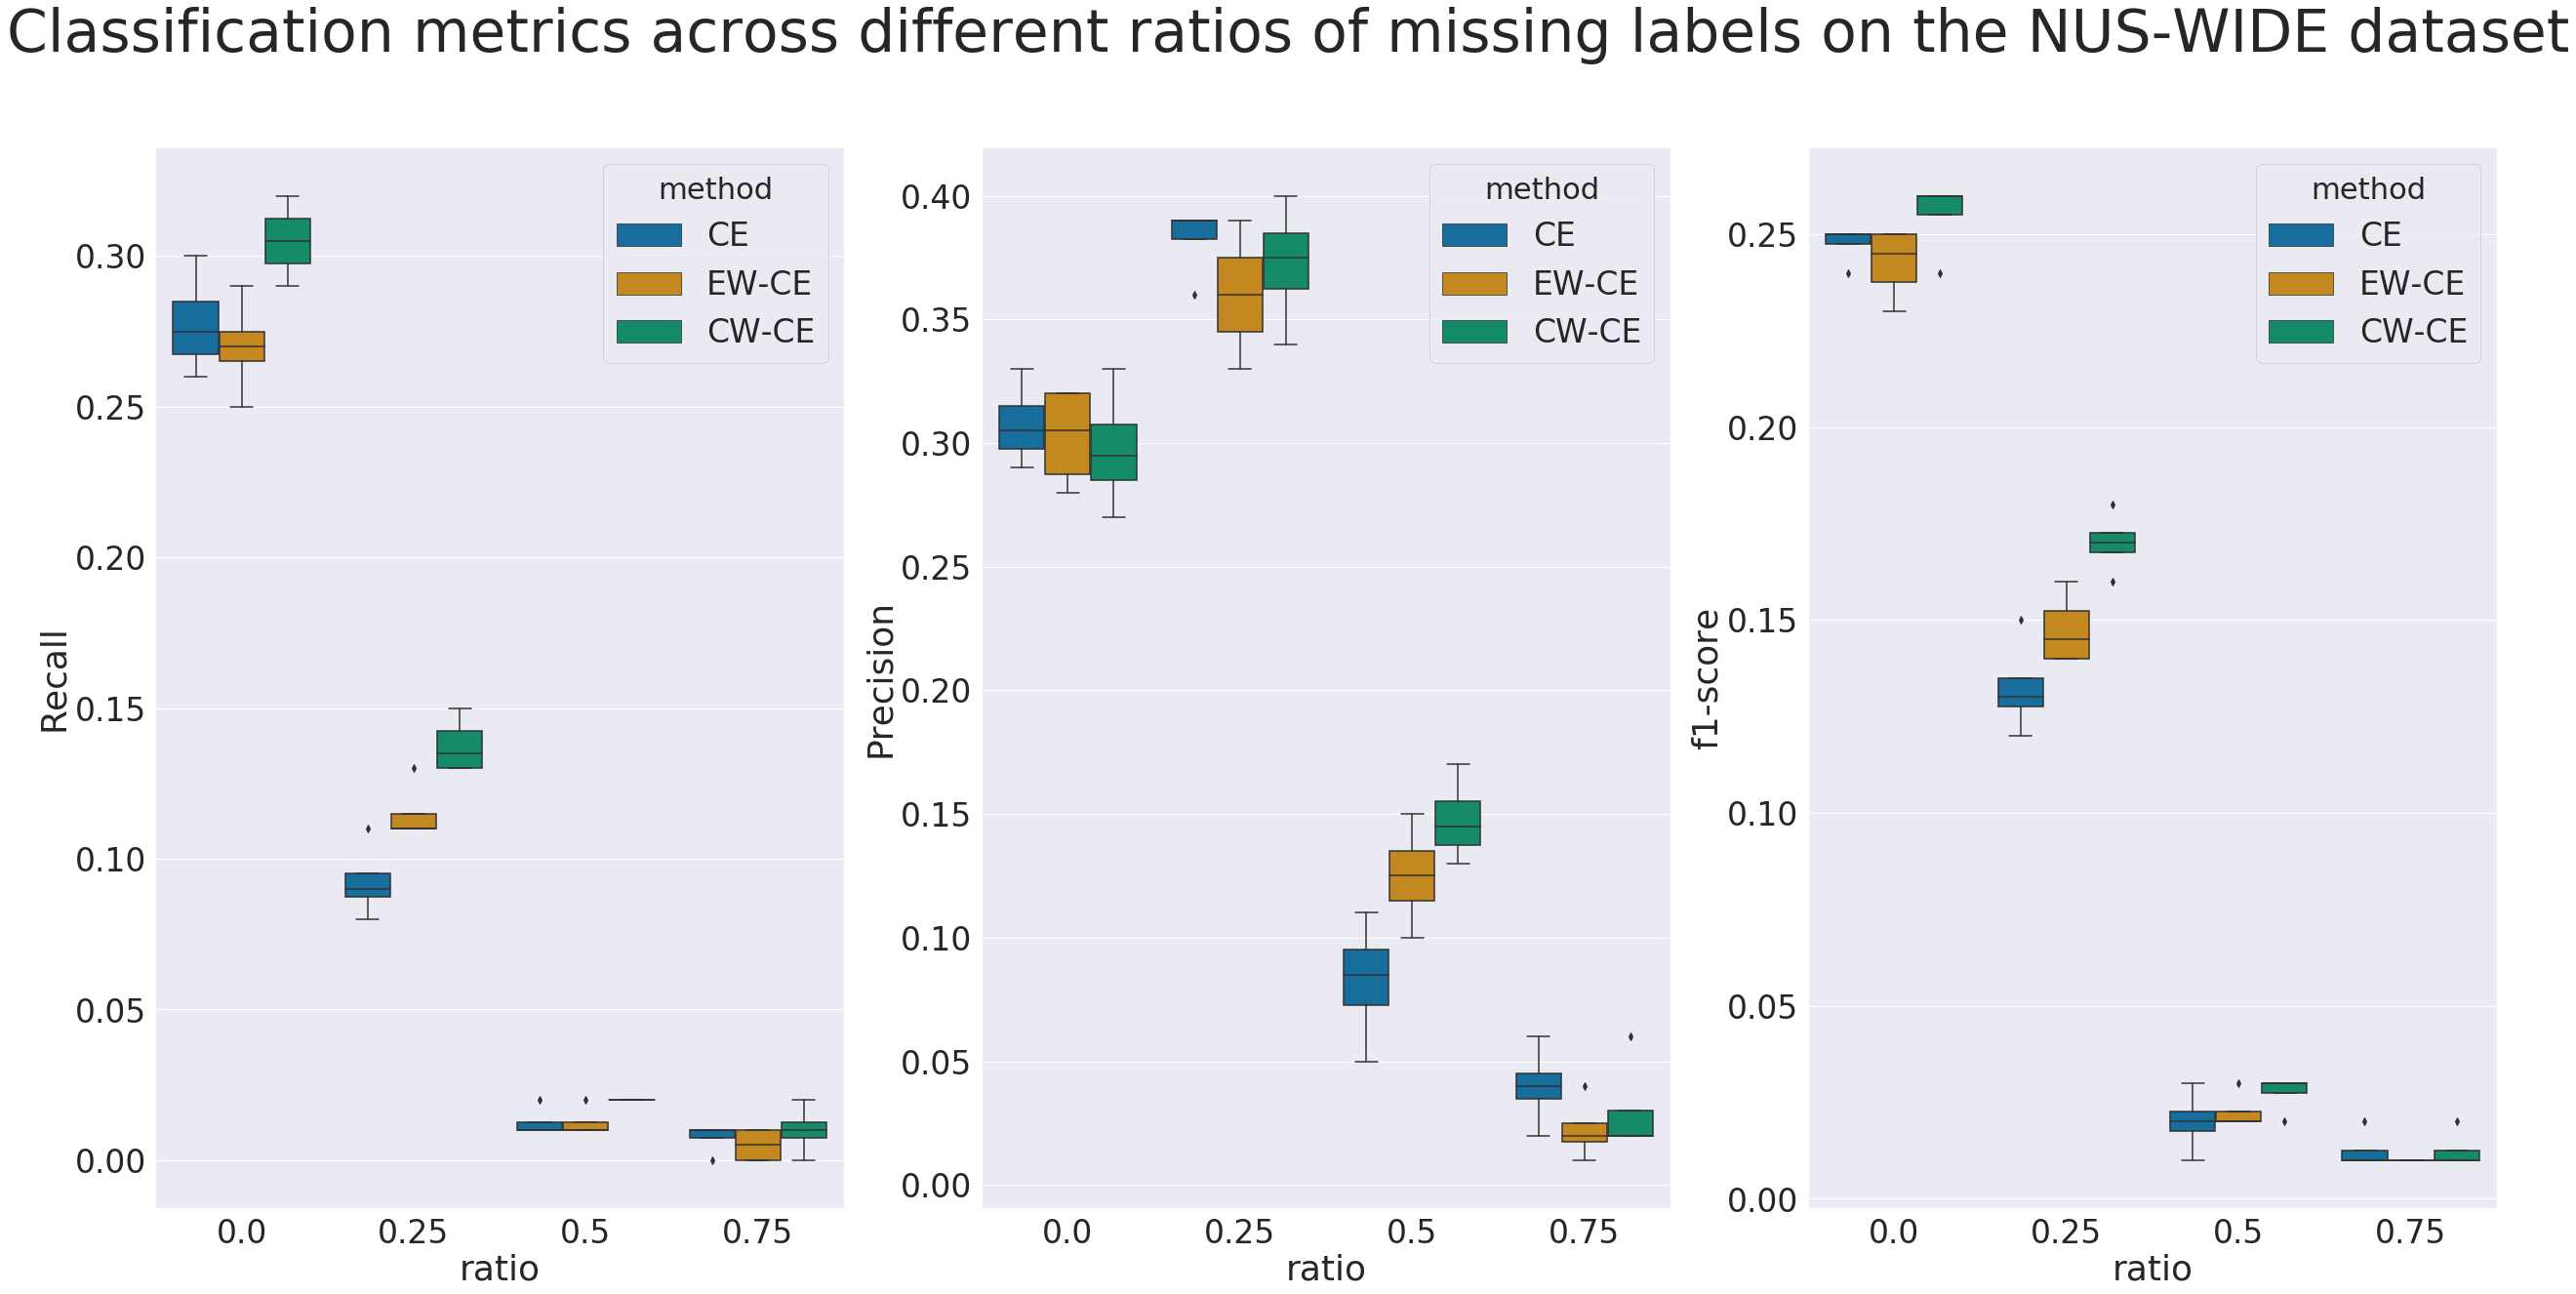

In [66]:
#sn.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":5})   
fig, ax_new = plt.subplots(1,3, sharey=False,figsize = [43,20])
columns_To_plot = all_results.columns[:-2]
for column, plot_column in zip(columns_To_plot,ax_new.flatten()):
    sn.boxplot(y=column, x='ratio', 
                     data=all_results, 
                     palette="colorblind",
                     hue='method',ax =plot_column)
#fig.set_xlabel("X Label",fontsize=30)
#fig.set_ylabel("Y Label",fontsize=20)
fig.suptitle("Classification metrics across different ratios of missing labels on the NUS-WIDE dataset", fontsize=60)                           
#[x.set_xlabel('Ratio', fontsize = 20)for y in ax_new for x in y]

## Micro results


In [2]:
OUTPUT_PATH ="/srv/workspace/research/mlml/experiments_results_nus/"
MICRO_OCE_results_pd = pd.DataFrame()
for split in np.arange(1,5):
    for ratio in np.arange(0,1,0.25): 
        experiment_path = OUTPUT_PATH+'nus_3labels_original_CE'  + str(round(ratio, 1)) + 'split_' + str(split)
        dirs = os.listdir(experiment_path)
        predictions = np.loadtxt(experiment_path + '/' + dirs[0] + '/predictions.out',delimiter=',')
        groundtruth = np.loadtxt(experiment_path + '/' + dirs[0] + '/test_ground_truth_classes.txt',delimiter=',')
        pred_rounded = np.round(predictions)
        recall = recall_score(groundtruth, pred_rounded, average='micro')
        precision = precision_score(groundtruth, pred_rounded, average='micro')
        f1 = f1_score(groundtruth, pred_rounded, average='micro')
        auc = roc_auc_score(groundtruth, predictions, average='micro')
        split_ratio_results = pd.DataFrame({"Recall": [recall], "Precision": [precision], "f1-score": [f1], 'AUC' : [auc]})
        split_ratio_results['ratio'] = ratio
        MICRO_OCE_results_pd = pd.concat([MICRO_OCE_results_pd,split_ratio_results])

In [3]:
OUTPUT_PATH ="/srv/workspace/research/mlml/experiments_results_nus/"
MICRO_weighted_CE_results_pd = pd.DataFrame()
for split in np.arange(1,5):
    for ratio in np.arange(0,1,0.25): 
        experiment_path = OUTPUT_PATH+'nus_3labels_weighted_CE'  + str(round(ratio, 1)) + 'split_' + str(split)
        dirs = os.listdir(experiment_path)
        predictions = np.loadtxt(experiment_path + '/' + dirs[0] + '/predictions.out',delimiter=',')
        groundtruth = np.loadtxt(experiment_path + '/' + dirs[0] + '/test_ground_truth_classes.txt',delimiter=',')
        pred_rounded = np.round(predictions)
        recall = recall_score(groundtruth, pred_rounded, average='micro')
        precision = precision_score(groundtruth, pred_rounded, average='micro')
        f1 = f1_score(groundtruth, pred_rounded, average='micro')
        auc = roc_auc_score(groundtruth, predictions, average='micro')
        split_ratio_results = pd.DataFrame({"Recall": [recall], "Precision": [precision], "f1-score": [f1], 'AUC' : [auc]})
        split_ratio_results['ratio'] = ratio
        #split_ratio_results['split'] = split 
        MICRO_weighted_CE_results_pd = pd.concat([MICRO_weighted_CE_results_pd,split_ratio_results])

In [4]:
OUTPUT_PATH ="/srv/workspace/research/mlml/experiments_results_nus/"
MICRO_correlation_CE_results_pd = pd.DataFrame()
for split in np.arange(1,5):
    for ratio in np.arange(0,1,0.25): 
        experiment_path = OUTPUT_PATH+'nus_3labels_correlations_CE'  + str(round(ratio, 1)) + 'split_' + str(split)
        dirs = os.listdir(experiment_path)
        predictions = np.loadtxt(experiment_path + '/' + dirs[0] + '/predictions.out',delimiter=',')
        groundtruth = np.loadtxt(experiment_path + '/' + dirs[0] + '/test_ground_truth_classes.txt',delimiter=',')
        pred_rounded = np.round(predictions)
        recall = recall_score(groundtruth, pred_rounded, average='micro')
        precision = precision_score(groundtruth, pred_rounded, average='micro')
        f1 = f1_score(groundtruth, pred_rounded, average='micro')
        auc = roc_auc_score(groundtruth, predictions, average='micro')
        split_ratio_results = pd.DataFrame({"Recall": [recall], "Precision": [precision], "f1-score": [f1], 'AUC' : [auc]})
        split_ratio_results['ratio'] = ratio
        #split_ratio_results['split'] = split 
        MICRO_correlation_CE_results_pd = pd.concat([MICRO_correlation_CE_results_pd,split_ratio_results])

In [5]:
MICRO_OCE_results_pd['method'] = 'CE'
MICRO_weighted_CE_results_pd['method']= 'IM-WCE'
MICRO_correlation_CE_results_pd['method'] = 'CB-WCE'
all_results = pd.concat([MICRO_OCE_results_pd,MICRO_weighted_CE_results_pd,MICRO_correlation_CE_results_pd])

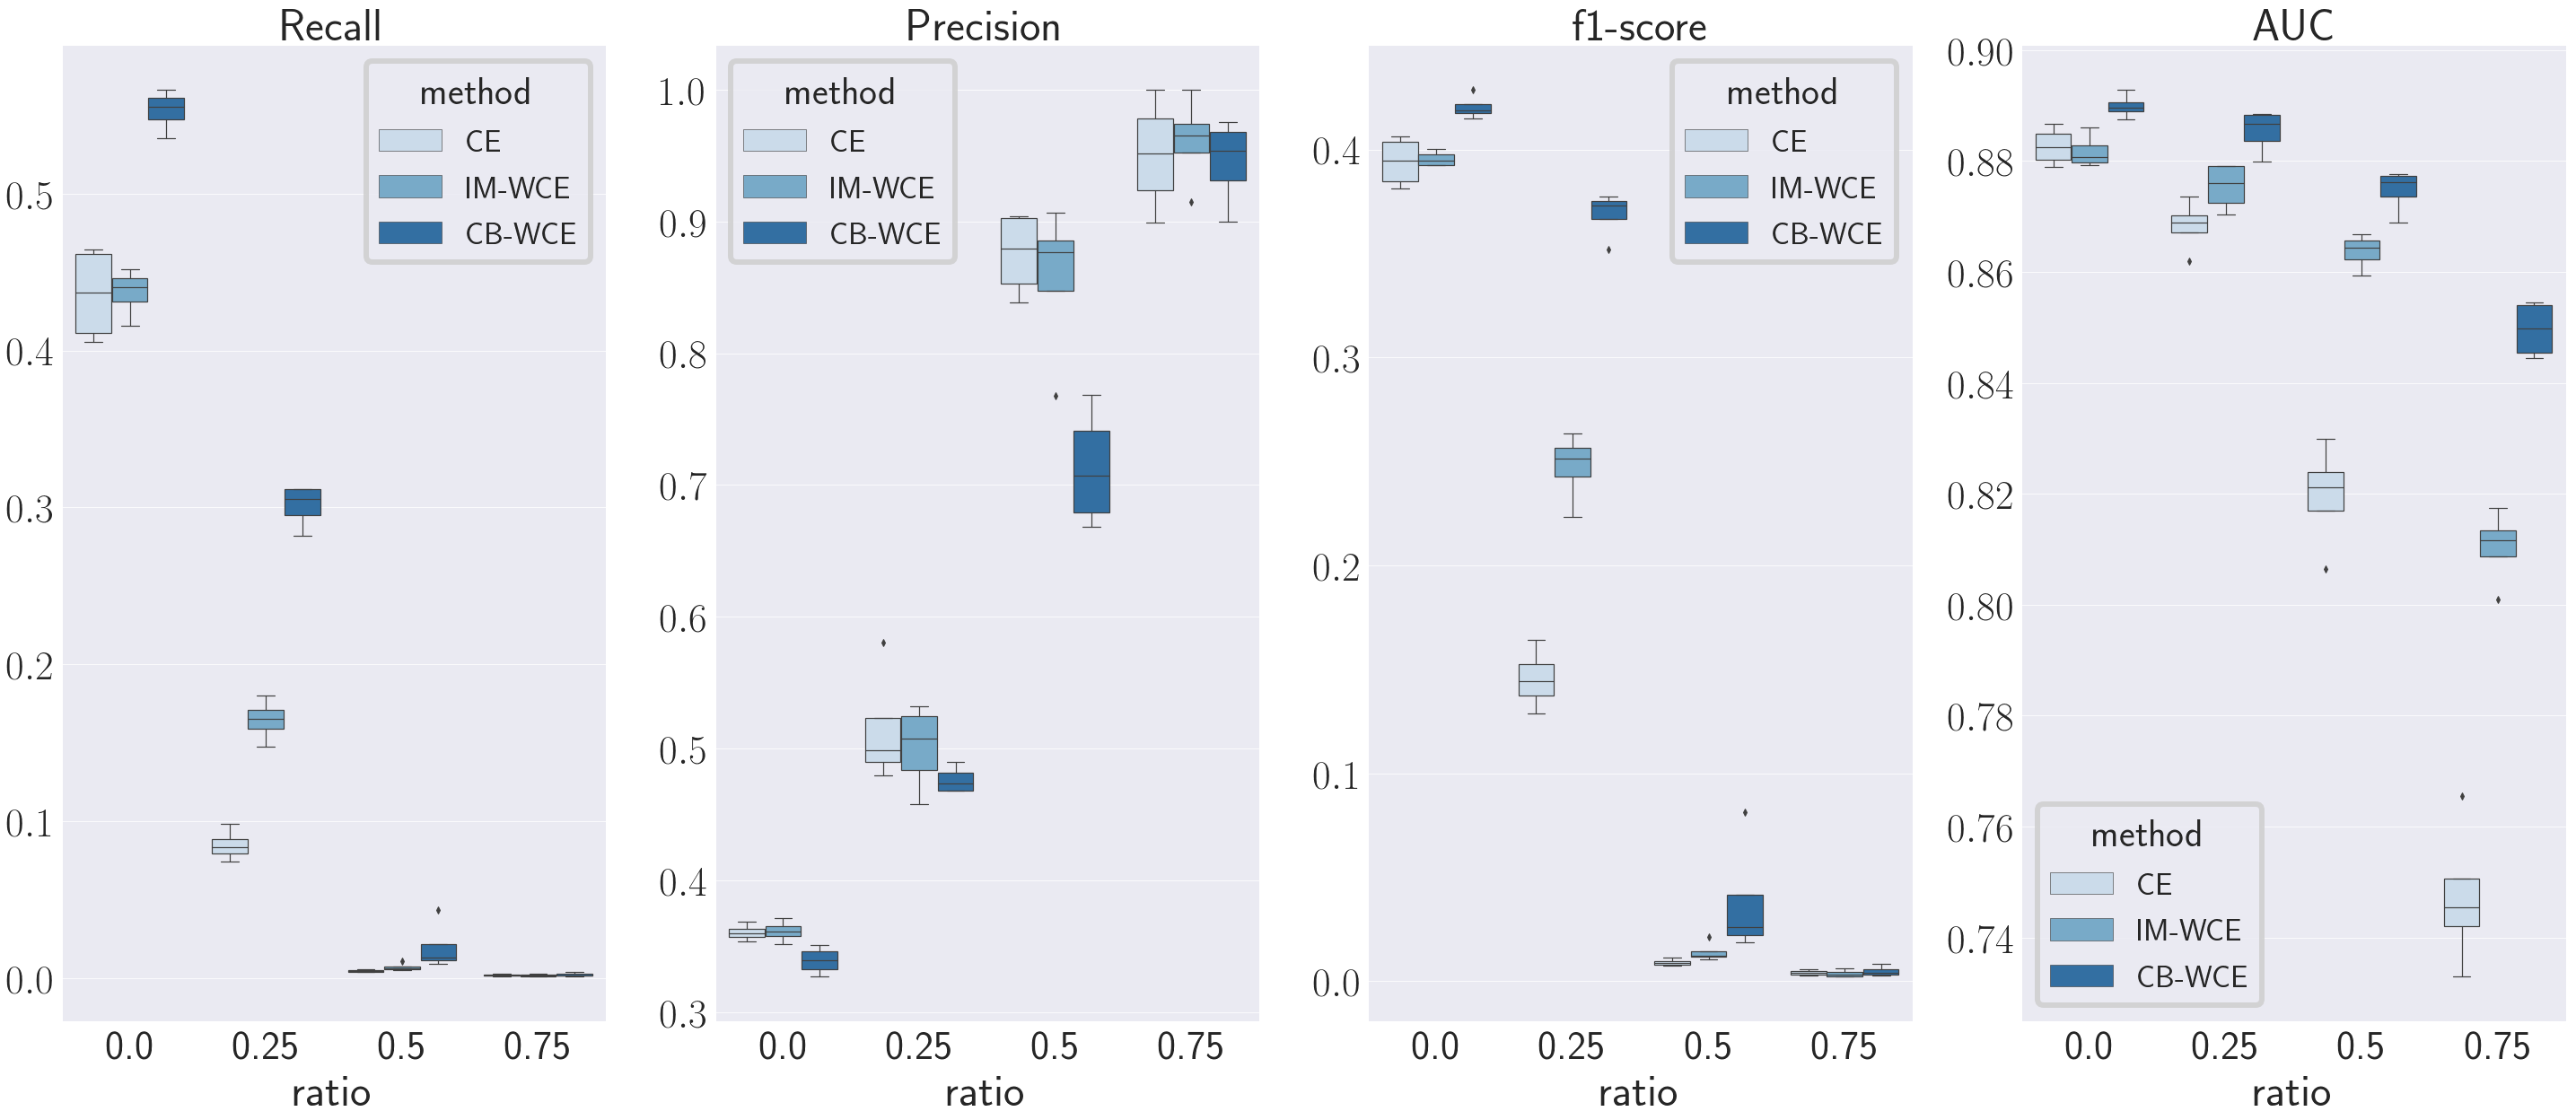

In [8]:
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

sn.set_context("paper", rc={"font.size":50,"axes.titlesize":50,
    "axes.labelsize" : 50,
    "xtick.labelsize" : 45,
    "ytick.labelsize" : 45,
    "legend.fontsize":35 })  
plt.rcParams['patch.linewidth'] = 6
plt.rcParams['patch.edgecolor'] = 'black'
plt.rcParams["patch.force_edgecolor"] = True

#sn.set(font_scale=3)  # for label size
fig, ax_new = plt.subplots(1,4, sharey=False,figsize = [50,20])
columns_To_plot = all_results.columns[:-2]
for column, plot_column in zip(columns_To_plot,ax_new.flatten()):
    sn.boxplot(y=column, x='ratio', 
                     data=all_results,
                     palette=sn.color_palette("Blues", 3),
                     hue='method',ax =plot_column)
    plot_column.title.set_text(column)
    plot_column.set_ylabel('')

#fig.set_xlabel("X Label",fontsize=30)
#fig.set_ylabel("Y Label",fontsize=20)
#fig.suptitle("Classification metrics across different ratios of missing labels on the NUS-WIDE dataset", fontsize=60)                           
#[x.set_xlabel('Ratio', fontsize = 20)for y in ax_new for x in y]
plt.savefig('/srv/workspace/research/mlml/figures/nusresults.pdf',dpi=300, format = 'pdf',bbox_inches='tight')


## Plotting true positives

In [116]:
OUTPUT_PATH ="/srv/workspace/research/mlml/experiments_results_nus/"
MICRO_OCE_results_pd = pd.DataFrame()
#for split in np.arange(1,5):
#    for ratio in np.arange(0,1,0.25): 
split = 1
ratio = 0.5
experiment_path = OUTPUT_PATH+'nus_3labels_original_CE'  + str(round(ratio, 1)) + 'split_' + str(split)
dirs = os.listdir(experiment_path)
predictions = np.loadtxt(experiment_path + '/' + dirs[0] + '/predictions.out',delimiter=',')
groundtruth = np.loadtxt(experiment_path + '/' + dirs[0] + '/test_ground_truth_classes.txt',delimiter=',')
pred_rounded_original = np.round(predictions)



experiment_path = OUTPUT_PATH+'nus_3labels_weighted_CE'  + str(round(ratio, 1)) + 'split_' + str(split)
dirs = os.listdir(experiment_path)
predictions = np.loadtxt(experiment_path + '/' + dirs[0] + '/predictions.out',delimiter=',')
groundtruth = np.loadtxt(experiment_path + '/' + dirs[0] + '/test_ground_truth_classes.txt',delimiter=',')
pred_rounded_weighted = np.round(predictions)


experiment_path = OUTPUT_PATH+'nus_3labels_correlations_CE'  + str(round(ratio, 1)) + 'split_' + str(split)
dirs = os.listdir(experiment_path)
predictions = np.loadtxt(experiment_path + '/' + dirs[0] + '/predictions.out',delimiter=',')
groundtruth = np.loadtxt(experiment_path + '/' + dirs[0] + '/test_ground_truth_classes.txt',delimiter=',')
pred_rounded_correlation = np.round(predictions)


In [117]:
model_output_rounded = pred_rounded_original
true_positives_perclass = sum((model_output_rounded == groundtruth) * (groundtruth == 1))
true_positives_df = pd.DataFrame(columns=LABELS_LIST)
true_positives_df.index.astype(str, copy=False)
true_positives_df.loc[0] = true_positives_perclass


model_output_rounded = pred_rounded_weighted
true_positives_perclass = sum((model_output_rounded == groundtruth) * (groundtruth == 1))
true_positives_df.loc[1] = true_positives_perclass


model_output_rounded = pred_rounded_correlation
true_positives_perclass = sum((model_output_rounded == groundtruth) * (groundtruth == 1))
true_positives_df.loc[2] = true_positives_perclass

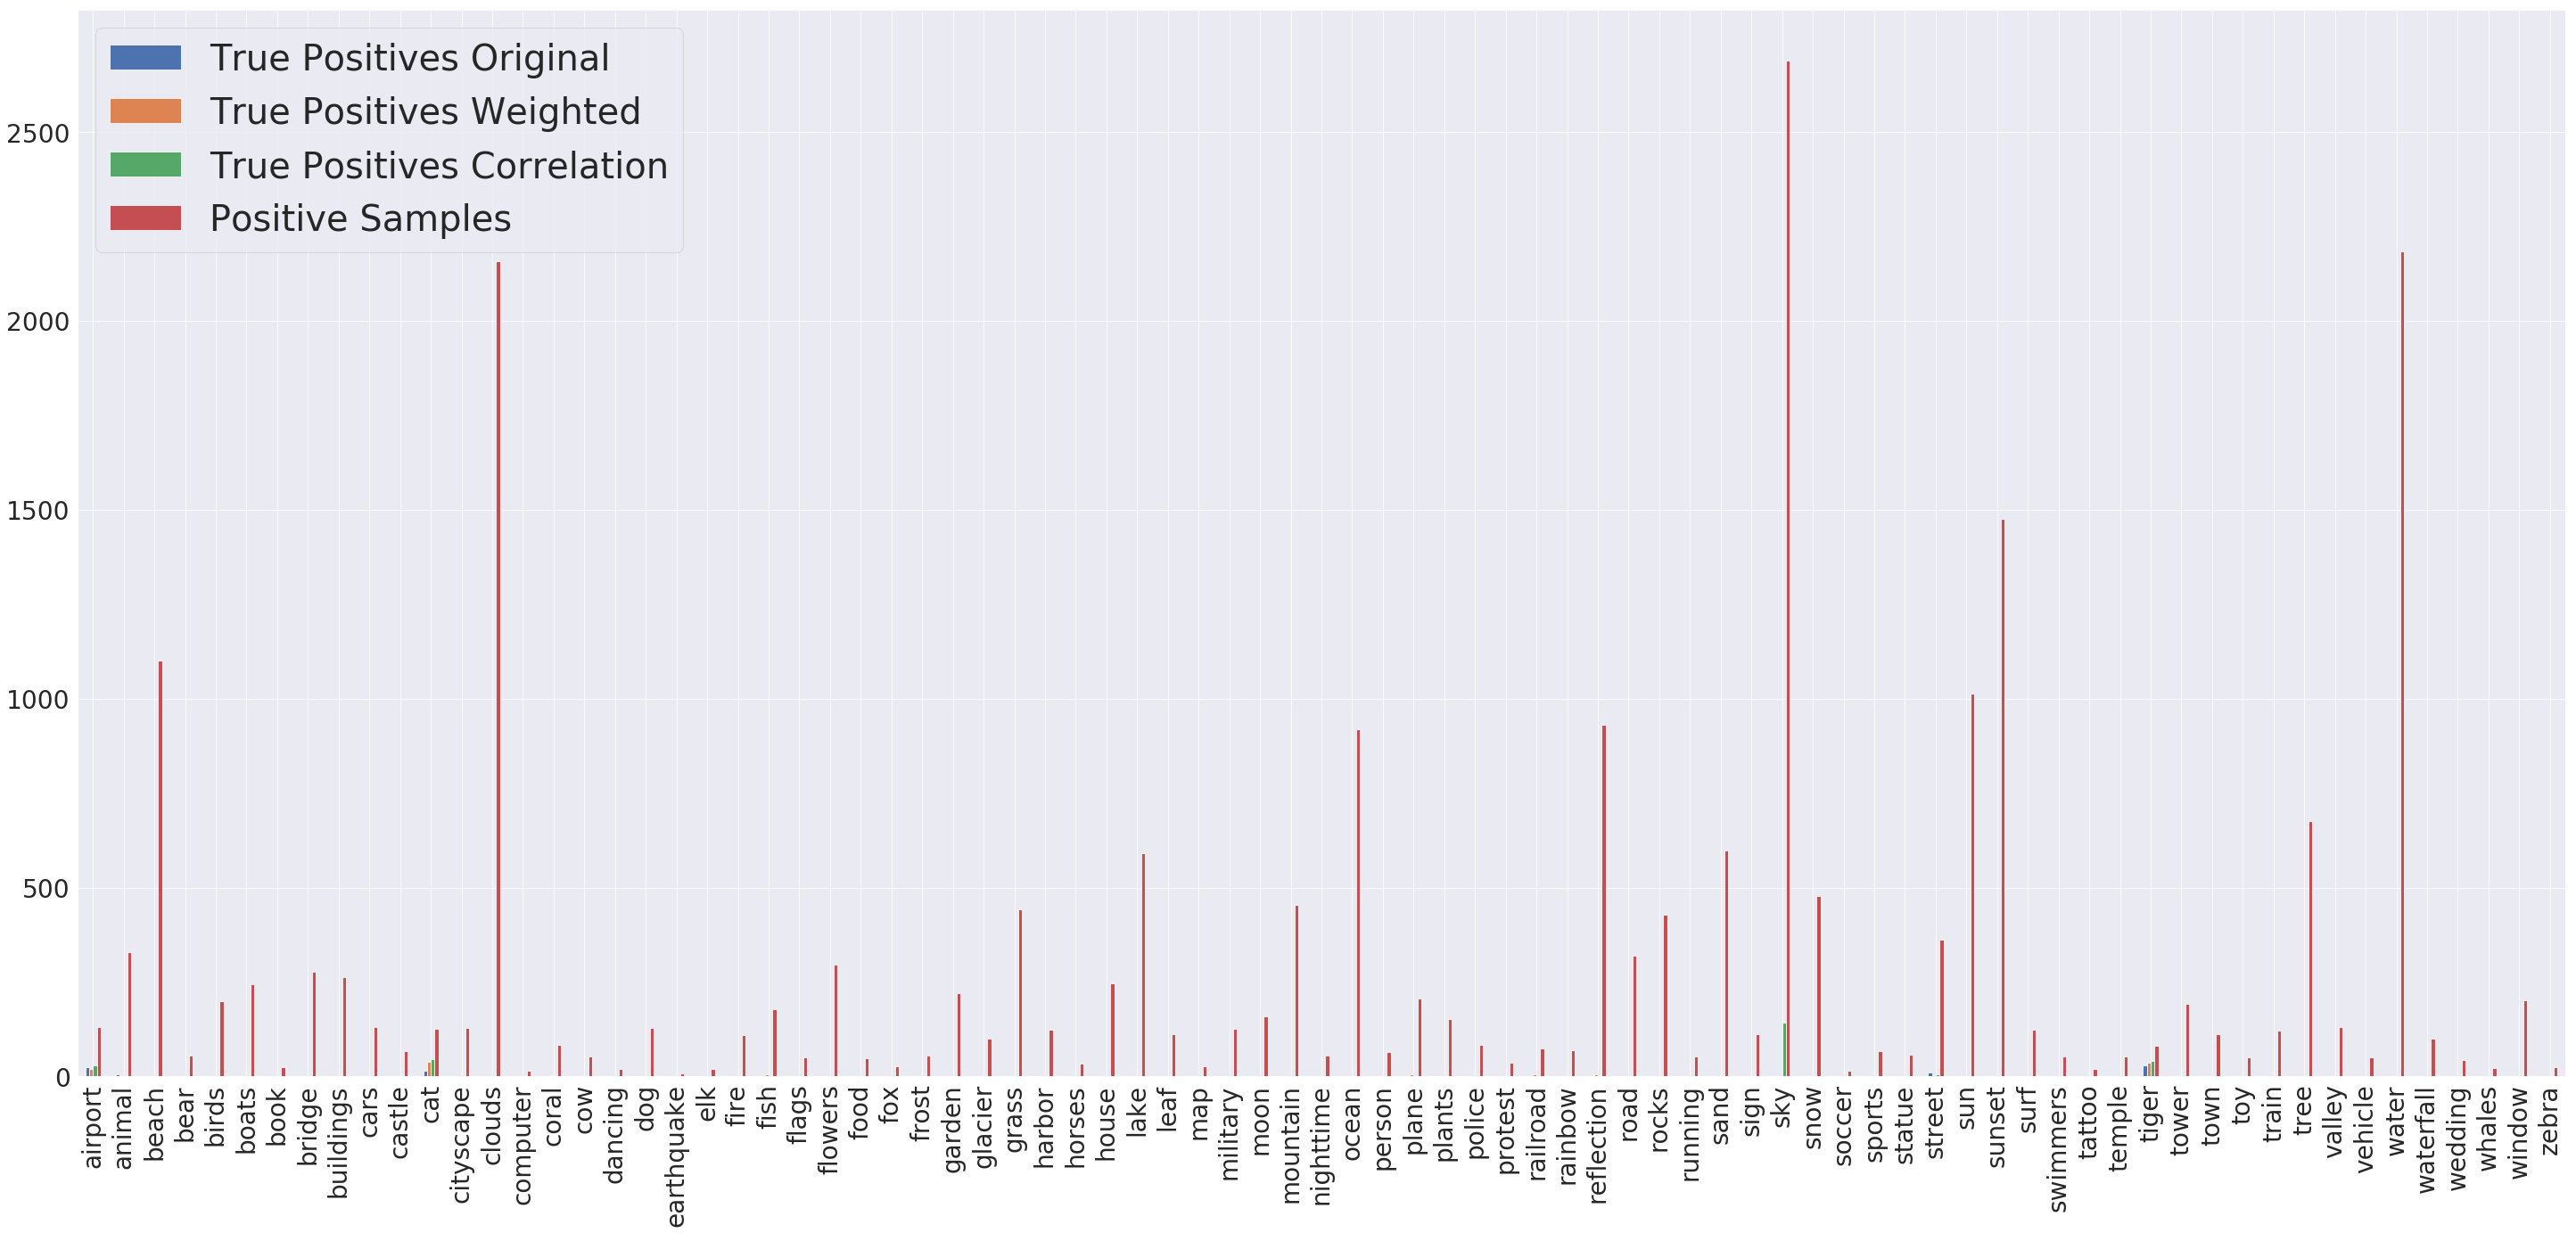

In [118]:
percentage_of_positives_perclass = sum(groundtruth)
true_positives_df.loc[3] = percentage_of_positives_perclass
true_positives_df.index = ['True Positives Original','True Positives Weighted','True Positives Correlation',
                           'Positive Samples']
true_positives_ratio_perclass = sum((model_output_rounded == groundtruth) * (groundtruth == 1)) / sum(groundtruth)
# Plot the figure
#labels = [label + " (" + "{:.1f}".format(true_positives_ratio_perclass[idx] * 100) + "%) " for idx, label in
#          enumerate(LABELS_LIST)]
#true_positives_df.columns = labels
true_positives_df.T.plot.bar(figsize=(50, 22), fontsize=28)